In [90]:
#Load in packages
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import contextily as cx
import warnings
import geoplot as gplt
import geoplot.crs as gcrs
from numpy import log10
import os
from shapely.geometry.point import Point
import matplotlib.cbook as cbook
from matplotlib.gridspec import GridSpec
import plotly.express as px

In [91]:
#Allow full display of columns in data
pd.set_option("display.max_columns", 100,"display.max_rows",100)

In [92]:
#Read in Durham Police Department call data
dpdcalls = gpd.read_file('/Users/sadiesheridan/Desktop/dpdshapefile/dpdshapefile.shp')
dpdcalls.set_crs('epsg:4326')
dpdcalls.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [93]:
#Determine which call types to keep with nature_list
nature_list = ('PANHANDLING OR NUISANCE', 'SUICIDE THREAT', 'INTOXICATED PERSON', 'MENTAL DISORDER', 'WELFARE CHECK', 'URGENT WELFARE CHECK', 'ASSIST PERSON', 'CRISIS', 'TRESPASS OR UNWANTED')

#Determine which priority levels to use for priority_list
priority_list = ['2', '3', '4', '5', '6']

#Determine which beats are in Durham
policebeats_list_obj = ['121', '122', '112', '111', '123', '114', '113', '124', '212', '214', '213', '211', '223', '222', '221', '224', '313', '312', '321', '314', '323', '324', '322', '311', '411', '415', '412', '413', '414', '422', '421', '423', '511', '512', '513']

In [94]:
#Filter out cancelled calls and self initiated calls
dpdcalls = dpdcalls.loc[dpdcalls["Source"] != "Self Initiated"].copy()
dpdcalls = dpdcalls.loc[dpdcalls["Cancelled"] == 0].copy()
dpdcalls = dpdcalls.loc[(dpdcalls["Beat"] != "DSO") & (dpdcalls["Beat"] != "SSA")].copy()

#Filter out for hang ups and unreadable natures (in the case that the call types in nature_list aren't specified)
# dpdcalls = dpdcalls.loc[dpdcalls["Nature"] != "HANG UP"].copy()
# dpdcalls = dpdcalls.loc[(dpdcalls["Nature"] != "HANG UP WIRELESS PHASE 1") & (dpdcalls["Nature"] != "0") & (dpdcalls["Nature"] != "16") & (dpdcalls["Nature"] != "DIRECTED PATROL") & (dpdcalls["Nature"] != "NO apt # or phone") & (dpdcalls["Nature"] != "\\") & (dpdcalls["Nature"] != "VIN: JHMFA36226S011840 not sto") & (dpdcalls["Nature"] != "DISy") & (dpdcalls["Nature"] != "VEr") & (dpdcalls["Nature"] != "DIST") & (dpdcalls['Nature'] != 'HANG UP WIRELESS PHASE 2')].copy()

#Filter out for only calls in nature_list
dpdcalls = dpdcalls[dpdcalls['Nature'].isin(nature_list)].copy()

#Filter out for only priority levels in priority_list
dpdcalls = dpdcalls[dpdcalls['Priority'].isin(priority_list)].copy()

#Filter out for only calls within Durham Police Beats
dpdcalls = dpdcalls.loc[dpdcalls['Beat'].isin(policebeats_list_obj)].copy()

#Filter out null x and y values
dpdcalls = dpdcalls.loc[(dpdcalls["X"] != 0) & (dpdcalls["Y"] != 0)].copy()

dpdcalls.head()

,Event Numb,Case Numbe,Call Date,Call Time,Source,Priority,Nature,Address,X,Y,District,Beat,Dispositio,Cancelled,geometry
74,21000113,None,1/1/2021,12:41:03AM,Wireless 911 Call,2,TRESPASS OR UNWANTED,2300 GUESS RD,2022916,828272,D2,211,Resolved Without Report,0,POINT (-78.92250 36.02572)
75,21000114,None,1/1/2021,12:41:53AM,Wireless 911 Call,3,CRISIS,0 HAYTI LN,2030397,813534,D4,411,Resolved Without Report,0,POINT (-78.89725 35.98522)
78,21000119,None,1/1/2021,12:44:24AM,E-911,3,WELFARE CHECK,500 E MAIN ST,2031074,816191,D5,513,Resolved Without Report,0,POINT (-78.89496 35.99252)
122,21000186,None,1/1/2021,1:19:04AM,E-911,3,TRESPASS OR UNWANTED,2100 N ROXBORO ST,2032434,825627,D2,213,Resolved Without Report,0,POINT (-78.89032 36.01843)
221,21000338,None,1/1/2021,4:26:38AM,Wireless 911 Call,3,CRISIS,200 N DRIVER ST,2036165,814339,D1,113,Resolved Without Report,0,POINT (-78.87775 35.98741)


In [95]:
#Create lists for specific beat groups
group1_list = [112, 113, 214, 223, 411, 511, 512, 513]
group2_list = [122, 222, 111, 213]
commsafe_list = [112, 113, 214, 223, 411, 511, 512, 513, 122, 222, 111, 213]

In [96]:
#Create the same lists to use when Beat is in object form
group1_list_obj = ['112', '113', '214', '223', '411', '511', '512', '513']
group2_list_obj = ['122', '222', '111', '213']
commsafe_list_obj = ['112', '113', '214', '223', '411', '511', '512', '513', '122', '222', '111', '213']

In [97]:
#Find most common Nature of calls
csdnature = dpdcalls.groupby(['Nature']).size().to_frame(name = 'Durham Beats Call Count').reset_index()
csdnature.sort_values(by='Durham Beats Call Count', inplace=True, ascending=False)
csdnature.head(20)

,Nature,Durham Beats Call Count
6,TRESPASS OR UNWANTED,4940
0,ASSIST PERSON,3053
7,URGENT WELFARE CHECK,1950
8,WELFARE CHECK,1651
1,CRISIS,1323
4,PANHANDLING OR NUISANCE,787
5,SUICIDE THREAT,582
2,INTOXICATED PERSON,440
3,MENTAL DISORDER,19


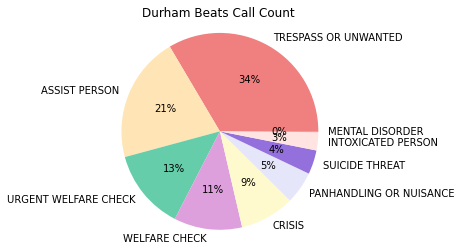

In [300]:
#Create a pie chart for the nature of calls
plt.pie(csdnature['Durham Beats Call Count'],autopct='%1.0f%%', labels=csdnature['Nature'], colors=['lightcoral', 'moccasin', 'mediumaquamarine', 'plum','lemonchiffon', 'lavender', 'mediumpurple', 'mistyrose'])
plt.axis('equal')
plt.title('Durham Beats Call Count')
plt.show()

In [99]:
#Find the most common Nature of comsafe call types for just comsafe beats
csdnature_commsafe = dpdcalls.loc[dpdcalls['Beat'].isin(commsafe_list_obj)].copy()
csdnature_commsafe = csdnature_commsafe.groupby(['Nature']).size().to_frame(name = 'Community Safety Beats Call Count').reset_index()
csdnature_commsafe.sort_values(by='Community Safety Beats Call Count', inplace=True, ascending=False)
csdnature_commsafe

,Nature,Community Safety Beats Call Count
6,TRESPASS OR UNWANTED,2210
0,ASSIST PERSON,975
7,URGENT WELFARE CHECK,615
1,CRISIS,545
8,WELFARE CHECK,520
4,PANHANDLING OR NUISANCE,371
5,SUICIDE THREAT,199
2,INTOXICATED PERSON,188
3,MENTAL DISORDER,11


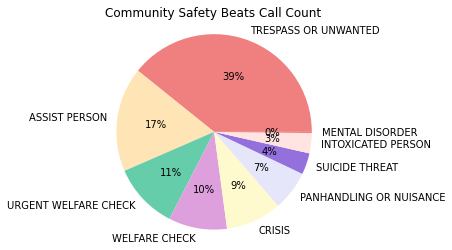

In [278]:
#Create a pie chart for the nature of calls for community safety beats
plt.pie(csdnature_commsafe['Community Safety Beats Call Count'], autopct='%1.0f%%'colors=['lightcoral', 'moccasin', 'mediumaquamarine', 'plum','lemonchiffon', 'lavender', 'mediumpurple', 'mistyrose'], labels=csdnature['Nature'], )
plt.axis('equal')
plt.title('Community Safety Beats Call Count')
plt.show()

In [183]:
#Merge the csd nature tables together
csdnature_counts = pd.merge(csdnature_commsafe, csdnature, on='Nature')
csdnature_counts = csdnature_counts.set_index('Nature')
csdnature_counts

,Community Safety Beats Call Count,Durham Beats Call Count
Nature,,
TRESPASS OR UNWANTED,2210,4940
ASSIST PERSON,975,3053
URGENT WELFARE CHECK,615,1950
CRISIS,545,1323
WELFARE CHECK,520,1651
PANHANDLING OR NUISANCE,371,787
SUICIDE THREAT,199,582
INTOXICATED PERSON,188,440
MENTAL DISORDER,11,19


In [111]:
#Find the most common Address of calls
calladdress = dpdcalls.groupby(['Address']).size().to_frame(name = 'Address Count').reset_index()
calladdress.sort_values(by='Address Count', inplace=True, ascending=False)
calladdress.head(10)

,Address,Address Count
1856,3400 HILLSBOROUGH RD,272
1268,2100 N ROXBORO ST,167
2837,800 W CLUB BLVD,149
416,1000 N MIAMI BLVD,148
598,1200 E MAIN ST,132
1506,2700 GUESS RD,108
2418,5000 NC 55 HWY,102
1219,2000 N ROXBORO ST,101
1920,3600 N ROXBORO ST,95
2470,5400 NEW HOPE COMMONS DR,91


In [182]:
#Find the most common address of calls for community safety beats
callsaddress_commsafe = dpdcalls.loc[dpdcalls['Beat'].isin(commsafe_list_obj)].copy()
callsaddress_commsafe = callsaddress_commsafe.groupby(['Address']).size().to_frame(name = 'Community Safety Address Count').reset_index()
callsaddress_commsafe.sort_values(by='Community Safety Address Count', inplace=True, ascending=False)
callsaddress_commsafe.head(10)

,Address,Community Safety Address Count
407,2100 N ROXBORO ST,167
113,1000 N MIAMI BLVD,148
175,1200 E MAIN ST,132
389,2000 N ROXBORO ST,101
561,3600 N ROXBORO ST,95
404,2100 HOLLOWAY ST,90
108,1000 N ALSTON AVE,81
728,600 E MAIN ST,80
600,400 LIBERTY ST,71
542,3200 N DUKE ST,68


In [115]:
#Read in policebeats data set
policebeats = gpd.read_file('/Users/sadiesheridan/Desktop/Police_Beats/Police_Beats.shp')
policebeats.set_crs('epsg:4326')
policebeats.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [116]:
#Filter out beats not in Durham for policebeats
policebeats_list = [121, 122, 112, 111, 123, 114, 113, 124, 212, 214, 213, 211, 223, 222, 221, 224, 313, 312, 321, 314, 323, 324, 322, 311, 411, 415, 412, 413, 414, 422, 421, 423, 511, 512, 513]
policebeats = policebeats.loc[policebeats["LAWBEAT"].isin(policebeats_list)].copy()
policebeats.head()

,OBJECTID,PERIMETER,STATUS,CONTIGUOUS,LAWDIST,LAWBEAT,CAD,GIS_DataA1,ShapeSTAre,ShapeSTLen,geometry
11,12,94210.453125,I,no,D2,224,224,None,7.014559e+07,94210.453140,"POLYGON ((-78.86340 36.13179, -78.86340 36.131..."
12,13,116621.601562,I,yes,D2,224,224,None,1.449941e+08,116621.571622,"POLYGON ((-78.91393 36.09660, -78.91391 36.096..."
13,14,12884.019531,I,no,D2,224,224,None,4.966974e+06,12884.022638,"POLYGON ((-78.87366 36.09793, -78.87363 36.097..."
14,15,16886.179688,I,no,D2,224,224,None,6.526409e+06,16886.182870,"POLYGON ((-78.88585 36.08830, -78.88585 36.088..."
15,16,50498.308594,I,yes,D2,222,222,None,1.066247e+08,50498.309761,"POLYGON ((-78.91508 36.07716, -78.91321 36.077..."


In [117]:
#Dissolving duplicate beats
policebeats = policebeats.to_crs("4326")
policebeats = policebeats.dissolve(by="LAWBEAT")
policebeats["LBeat"] = policebeats.index
policebeats = policebeats.reset_index()
policebeats["id"] = policebeats.index
policebeats.head()

,LAWBEAT,geometry,OBJECTID,PERIMETER,STATUS,CONTIGUOUS,LAWDIST,CAD,GIS_DataA1,ShapeSTAre,ShapeSTLen,LBeat,id
0,111,"POLYGON ((-78.89039 36.01517, -78.89038 36.015...",50,28608.800781,I,yes,D1,111,None,2.010252e+07,28608.799743,111,0
1,112,"POLYGON ((-78.88787 36.01473, -78.88734 36.014...",51,26265.849609,I,yes,D1,112,None,2.079934e+07,26265.852604,112,1
2,113,"POLYGON ((-78.87372 35.99369, -78.87458 35.991...",62,20667.539062,I,yes,D1,113,None,2.159195e+07,20667.538873,113,2
3,114,"MULTIPOLYGON (((-78.84053 35.95436, -78.84021 ...",65,53321.980469,I,yes,D1,114,None,6.103382e+07,53321.974873,114,3
4,121,"MULTIPOLYGON (((-78.80746 35.99706, -78.80746 ...",38,14495.120117,I,no,D1,121,None,7.008533e+06,14495.120026,121,4


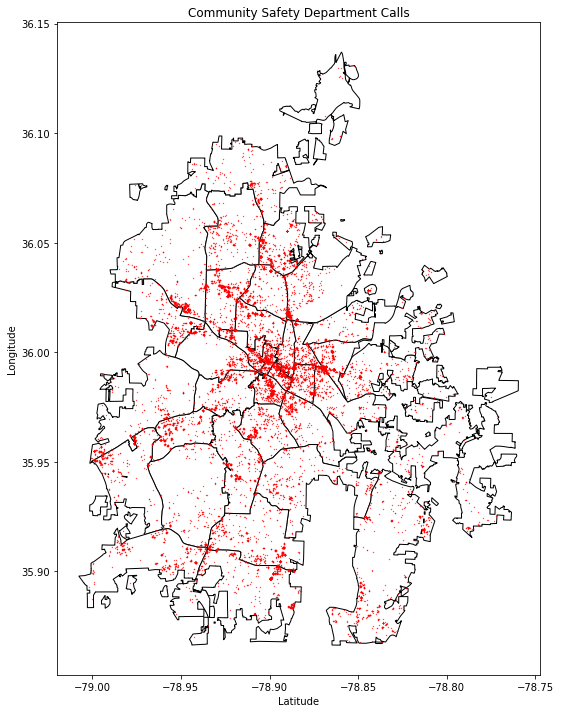

In [118]:
#Plot the two data sets together setting the aspect 'equal'
fig, ax = plt.subplots(figsize=(12, 12))

policebeats.plot(ax=ax, color='white', edgecolor='black')

dpdcalls.plot(ax=ax, marker='o', color='red', markersize=0.1)

ax.set(title='Community Safety Department Calls')
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [119]:
#Filter calls and police beats for just community safety beats
commsafe_beats = policebeats.loc[policebeats['LAWBEAT'].isin(commsafe_list)].copy()

commsafe_calls = dpdcalls.loc[dpdcalls['Beat'].isin(commsafe_list_obj)].copy()

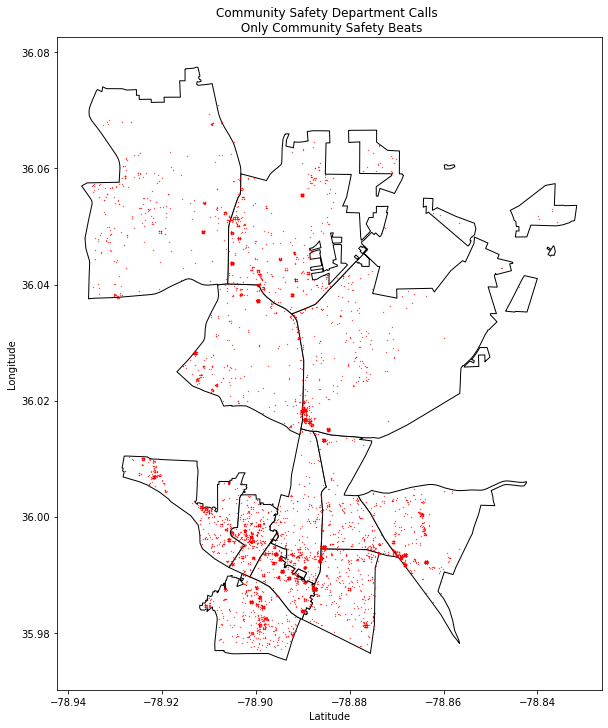

In [120]:
#Plot the two data sets together setting the aspect 'equal'
fig, ax = plt.subplots(figsize=(12, 12))

commsafe_beats.plot(ax=ax, color='white', edgecolor='black')

commsafe_calls.plot(ax=ax, marker='o', color='red', markersize=0.1)

ax.set(title='Community Safety Department Calls \n Only Community Safety Beats')
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

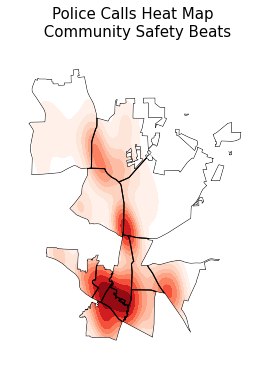

In [121]:
#Heat map of calls
ax = gplt.kdeplot(
    commsafe_calls, clip=commsafe_beats.geometry,
    shade=True, cmap='Reds',
    projection=gplt.crs.AlbersEqualArea())
gplt.polyplot(commsafe_beats, ax=ax, zorder=1, edgecolor='Black')

plt.title("Police Calls Heat Map \n Community Safety Beats", fontsize = 15)
plt.show()

In [122]:
#Merge policebats data with call data using polygon geometry
policebeats_w_dpd = gpd.sjoin(policebeats, dpdcalls)
policebeats_w_dpd.info

<bound method DataFrame.info of     LAWBEAT                                           geometry  OBJECTID  \
0       111  POLYGON ((-78.89039 36.01517, -78.89038 36.015...        50   
0       111  POLYGON ((-78.89039 36.01517, -78.89038 36.015...        50   
0       111  POLYGON ((-78.89039 36.01517, -78.89038 36.015...        50   
0       111  POLYGON ((-78.89039 36.01517, -78.89038 36.015...        50   
0       111  POLYGON ((-78.89039 36.01517, -78.89038 36.015...        50   
..      ...                                                ...       ...   
34      513  POLYGON ((-78.89561 35.99710, -78.89553 35.997...        61   
34      513  POLYGON ((-78.89561 35.99710, -78.89553 35.997...        61   
34      513  POLYGON ((-78.89561 35.99710, -78.89553 35.997...        61   
34      513  POLYGON ((-78.89561 35.99710, -78.89553 35.997...        61   
34      513  POLYGON ((-78.89561 35.99710, -78.89553 35.997...        61   

       PERIMETER STATUS CONTIGUOUS LAWDIST  CAD GIS_Dat

In [123]:
#Grouping dpdcalls by beat
allcalls = policebeats_w_dpd.groupby(['LAWBEAT']).size().to_frame(name = 'calls_count').reset_index()
allcalls.head()

,LAWBEAT,calls_count
0,111,376
1,112,365
2,113,470
3,114,343
4,121,261


In [124]:
#Merge policebeats data with allcalls
callcount_beat = pd.merge(policebeats, allcalls, on ='LAWBEAT')
callcount_beat.head(3)

,LAWBEAT,geometry,OBJECTID,PERIMETER,STATUS,CONTIGUOUS,LAWDIST,CAD,GIS_DataA1,ShapeSTAre,ShapeSTLen,LBeat,id,calls_count
0,111,"POLYGON ((-78.89039 36.01517, -78.89038 36.015...",50,28608.800781,I,yes,D1,111,None,2.010252e+07,28608.799743,111,0,376
1,112,"POLYGON ((-78.88787 36.01473, -78.88734 36.014...",51,26265.849609,I,yes,D1,112,None,2.079934e+07,26265.852604,112,1,365
2,113,"POLYGON ((-78.87372 35.99369, -78.87458 35.991...",62,20667.539062,I,yes,D1,113,None,2.159195e+07,20667.538873,113,2,470


In [125]:
#Find the centroid of each polygon
callcount_beat['center'] = callcount_beat['geometry'].centroid
callcount_points = callcount_beat.copy()
callcount_points.set_geometry('center', inplace=True)

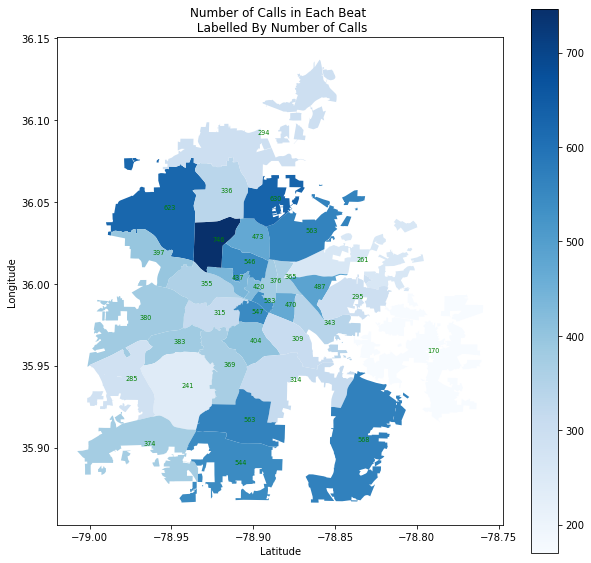

In [264]:
#Plot choropleth map of number of priority 2-6 calls with merged data
fig, ax = plt.subplots(figsize = (10,10))

callcount_beat.plot(column='calls_count',  
                         legend=True,  
                         cmap="Blues", ax=ax, aspect=1);

texts = []

for x, y, label in zip(callcount_points.geometry.x, callcount_points.geometry.y, callcount_points["calls_count"]):
    texts.append(plt.text(x, y, label, fontsize = 6.5, color='Green'))

ax.set(title='Number of Calls in Each Beat \n Labelled By Number of Calls')
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [127]:
#Filter for just community safety beats
callcount_beat_commsafe = callcount_beat.loc[callcount_beat['LAWBEAT'].isin(commsafe_list)]

#Find the centroid of each polygon
callcount_beat_commsafe['center'] = callcount_beat_commsafe['geometry'].centroid
callcount_commsafe_points = callcount_beat_commsafe.copy()
callcount_commsafe_points.set_geometry('center', inplace=True)

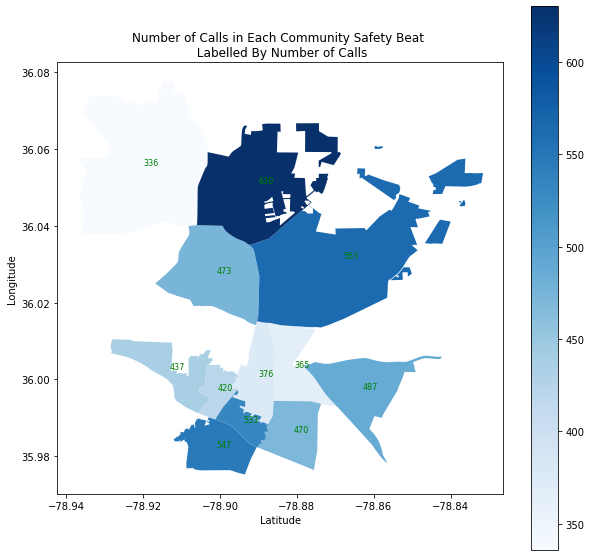

In [261]:
#Plot choropleth map of number of priority 2-6 calls with merged data
fig, ax = plt.subplots(figsize = (10,10))

callcount_beat_commsafe.plot(column='calls_count',  
                         legend=True,  
                         cmap="Blues", ax=ax, aspect=1);

texts = []

for x, y, label in zip(callcount_commsafe_points.geometry.x, callcount_commsafe_points.geometry.y, callcount_commsafe_points["calls_count"]):
    texts.append(plt.text(x, y, label, fontsize = 8, color='Green'))

ax.set(title='Number of Calls in Each Community Safety Beat \n Labelled By Number of Calls')
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [129]:
#Read in US Census Bureau data for North Carolina 2020 census blocks
ncblockmap = gpd.read_file('/Users/sadiesheridan/Desktop/tl_2021_37_tabblock20/tl_2021_37_tabblock20.shp')

#Set the crs for the census data
ncblockmap = ncblockmap.to_crs("EPSG:4326")

#Filter the block map to only include Durham blocks (63)
durhamblockmap = ncblockmap[ncblockmap["COUNTYFP20"]=="063"]

In [130]:
#Assign each census block to a police beat with for loop
#Uses census block geometry from 2020
cblockIndexToBeat = {}
sIndex = policebeats.sindex

for cblock_ind in durhamblockmap.index:
    cblock_geom = durhamblockmap.loc[cblock_ind]["geometry"]
    possibleBeatMatches = list(sIndex.intersection(cblock_geom.bounds))
    matched = False

    if len(possibleBeatMatches) > 0:
        possibleMatches = policebeats.iloc[possibleBeatMatches]
        intersectingAreas = possibleMatches.intersection(cblock_geom).area
        intersectingAreas /= cblock_geom.area
        police_beat_index = intersectingAreas.idxmax()
        maxIntersection = intersectingAreas.max()
    ##########
        if maxIntersection < 0.1:
            continue
    ##########
        if maxIntersection > 0:
            cblockIndexToBeat[cblock_ind] = policebeats.loc[police_beat_index]['LAWBEAT']
            matched = True

cblockDurhamBeats = ncblockmap[ncblockmap.index.isin(cblockIndexToBeat)]
cblockDurhamBeats['Beat'] = cblockDurhamBeats.index.map(lambda ii: cblockIndexToBeat[ii])

warnings.filterwarnings('ignore')

In [131]:
#Load in 2020 race data from census bureau
#Data is from 2020 US Census Bureau filtered by census blocks for Durham
racedata = pd.read_csv('/Users/sadiesheridan/Downloads/Race data/DECENNIALPL2020.P1_data_with_overlays_2022-06-06T132656.csv', skiprows = 1)

#Change id variable to GEOID20
racedata['GEOID20'] = racedata['id'].str[-15:]
racedata.drop('id', axis=1, inplace=True)

#Merging race data into the police beat and block data
raceineachbeat = pd.merge(racedata, cblockDurhamBeats)

#Grouping the population by police beat
raceineachbeat = raceineachbeat.groupby('Beat', as_index=False).sum()

#Adding beat geometry
raceineachbeat = pd.merge(policebeats, raceineachbeat, left_on='LAWBEAT', right_on='Beat')

#Change the column names for raceineachbeat
raceineachbeat.columns = raceineachbeat.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
raceineachbeat.columns = raceineachbeat.columns.str.replace('[#,@,&,!]', '')
raceineachbeat.columns = raceineachbeat.columns.str.replace('[:]', '_')
warnings.filterwarnings('ignore')

#Adding new columns to race in police beat data set
raceineachbeat['area'] = raceineachbeat.area
raceineachbeat['popdensity']= raceineachbeat['total_'] / raceineachbeat['area']
raceineachbeat['propwhite']= raceineachbeat['total_population_of_one_race_white_alone'] / raceineachbeat['total_']
raceineachbeat['propblack']= raceineachbeat['total_population_of_one_race_black_or_african_american_alone'] / raceineachbeat['total_']
raceineachbeat['propnativeamerican']= raceineachbeat['total_population_of_one_race_american_indian_and_alaska_native_alone'] / raceineachbeat['total_']
raceineachbeat['propasian']= raceineachbeat['total_population_of_one_race_asian_alone'] / raceineachbeat['total_']
raceineachbeat['proppacislander']= raceineachbeat['total_population_of_one_race_native_hawaiian_and_other_pacific_islander_alone'] / raceineachbeat['total_']
raceineachbeat['other']= raceineachbeat['total_'] - raceineachbeat['total_population_of_one_race_']
raceineachbeat['propother']= raceineachbeat['other'] / raceineachbeat['total_']
raceineachbeat.head()

,lawbeat,geometry,objectid,perimeter,status,contiguous,lawdist,cad,gis_dataa1,shapestare,shapestlen,lbeat,id,beat,total_,total_population_of_one_race_,total_population_of_one_race_white_alone,total_population_of_one_race_black_or_african_american_alone,total_population_of_one_race_american_indian_and_alaska_native_alone,total_population_of_one_race_asian_alone,total_population_of_one_race_native_hawaiian_and_other_pacific_islander_alone,total_population_of_one_race_some_other_race_alone,total_population_of_two_or_more_races_,total_population_of_two_or_more_races_population_of_two_races_,total_population_of_two_or_more_races_population_of_two_races_white;_black_or_african_american,total_population_of_two_or_more_races_population_of_two_races_white;_american_indian_and_alaska_native,total_population_of_two_or_more_races_population_of_two_races_white;_asian,total_population_of_two_or_more_races_population_of_two_races_white;_native_hawaiian_and_other_pacific_islander,total_population_of_two_or_more_races_population_of_two_races_white;_some_other_race,total_population_of_two_or_more_races_population_of_two_races_black_or_african_american;_american_indian_and_alaska_native,total_population_of_two_or_more_races_population_of_two_races_black_or_african_american;_asian,total_population_of_two_or_more_races_population_of_two_races_black_or_african_american;_native_hawaiian_and_other_pacific_islander,total_population_of_two_or_more_races_population_of_two_races_black_or_african_american;_some_other_race,total_population_of_two_or_more_races_population_of_two_races_american_indian_and_alaska_native;_asian,total_population_of_two_or_more_races_population_of_two_races_american_indian_and_alaska_native;_native_hawaiian_and_other_pacific_islander,total_population_of_two_or_more_races_population_of_two_races_american_indian_and_alaska_native;_some_other_race,total_population_of_two_or_more_races_population_of_two_races_asian;_native_hawaiian_and_other_pacific_islander,total_population_of_two_or_more_races_population_of_two_races_asian;_some_other_race,total_population_of_two_or_more_races_population_of_two_races_native_hawaiian_and_other_pacific_islander;_some_other_race,total_population_of_two_or_more_races_population_of_three_races_,total_population_of_two_or_more_races_population_of_three_races_white;_black_or_african_american;_american_indian_and_alaska_native,total_population_of_two_or_more_races_population_of_three_races_white;_black_or_african_american;_asian,total_population_of_two_or_more_races_population_of_three_races_white;_black_or_african_american;_native_hawaiian_and_other_pacific_islander,total_population_of_two_or_more_races_population_of_three_races_white;_black_or_african_american;_some_other_race,total_population_of_two_or_more_races_population_of_three_races_white;_american_indian_and_alaska_native;_asian,total_population_of_two_or_more_races_population_of_three_races_white;_american_indian_and_alaska_native;_native_hawaiian_and_other_pacific_islander,total_population_of_two_or_more_races_population_of_three_races_white;_american_indian_and_alaska_native;_some_other_race,total_population_of_two_or_more_races_population_of_three_races_white;_asian;_native_hawaiian_and_other_pacific_islander,total_population_of_two_or_more_races_population_of_three_races_white;_asian;_some_other_race,total_population_of_two_or_more_races_population_of_three_races_white;_native_hawaiian_and_other_pacific_islander;_some_other_race,total_population_of_two_or_more_races_population_of_three_races_black_or_african_american;_american_indian_and_alaska_native;_asian,total_population_of_two_or_more_races_population_of_three_races_black_or_african_american;_american_indian_and_alaska_native;_native_hawaiian_and_other_pacific_islander,total_population_of_two_or_more_races_population_of_three_races_black_or_african_american;_american_indian_and_alaska_native;_some_other_race,total_population_of_two_or_more_races_population_of_three_races_black_or_afric

In [132]:
#Find the centroid of each polygon
raceineachbeat['center'] = raceineachbeat['geometry'].centroid
raceineachbeat_points = raceineachbeat.copy()
raceineachbeat_points.set_geometry('center', inplace=True)

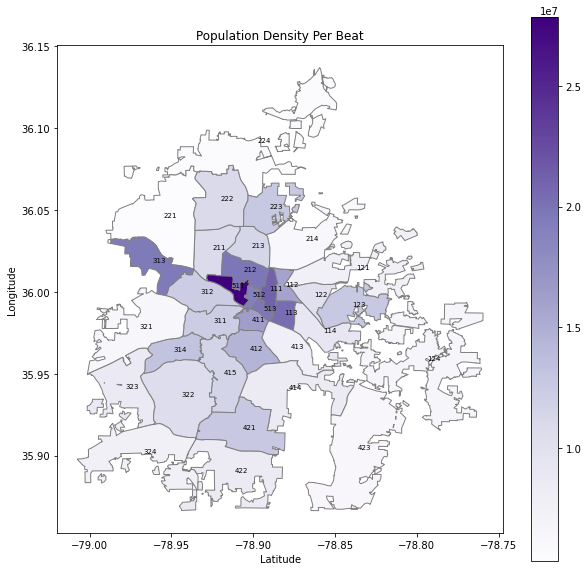

In [133]:
#Plot the population density data by beat
fig, ax = plt.subplots(figsize = (10,10))
raceineachbeat.plot(column='popdensity',
                                legend=True,
                                cmap="Purples", ax=ax, aspect=1, edgecolor='gray');

texts = []

for x, y, label in zip(raceineachbeat_points.geometry.x, raceineachbeat_points.geometry.y, raceineachbeat_points["lawbeat"]):
    texts.append(plt.text(x, y, label, fontsize = 7))

plt.title("Population Density Per Beat")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [134]:
#Print the five beats with the highest population density
population_density = raceineachbeat[['lawbeat', 'popdensity']]
population_density.sort_values(by='popdensity', inplace=True, ascending=False)
population_density.head(10)

,lawbeat,popdensity
32,511,2.783313e+07
0,111,2.115229e+07
2,113,2.041984e+07
34,513,1.981489e+07
9,212,1.977689e+07
18,313,1.955184e+07
33,512,1.904815e+07
24,411,1.640552e+07
1,112,1.595999e+07
25,412,1.447698e+07


In [135]:
#Filter raceineachbeat for community safety beats
raceineachbeat_commsafe = raceineachbeat.loc[raceineachbeat['lawbeat'].isin(commsafe_list)]

#Find the centroid of each polygon
raceineachbeat_commsafe['center'] = raceineachbeat_commsafe['geometry'].centroid
raceineachbeat_commsafe_points = raceineachbeat_commsafe.copy()
raceineachbeat_commsafe_points.set_geometry('center', inplace=True)

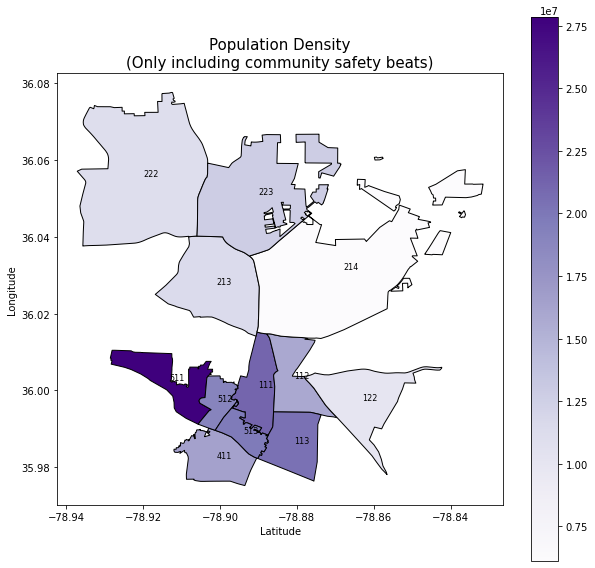

In [136]:
#Plot the population density by beat for com safe beats
fig, ax = plt.subplots(figsize = (10,10))
raceineachbeat_commsafe.plot(column='popdensity',
                                legend=True,
                                cmap="Purples", ax=ax, aspect=1, edgecolor='black');

texts = []

for x, y, label in zip(raceineachbeat_commsafe_points.geometry.x, raceineachbeat_commsafe_points.geometry.y, raceineachbeat_commsafe_points["lawbeat"]):
    texts.append(plt.text(x, y, label, fontsize = 8))

plt.title("Population Density\n(Only including community safety beats)", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [137]:
#Merge comsafenatures with csdnature
comsafenatures_count = dpdcalls.set_index('Nature').join(csdnature_counts)
comsafenatures_count = comsafenatures_count.reset_index()

#Create call count table for community safety nature calls by beat
allnaturecalls = dpdcalls.groupby(['Beat']).size().to_frame(name = 'nature_calls_count').reset_index()
allnaturecalls['Beat'] = allnaturecalls['Beat'].astype(str)

#Create call count table for trespass cases
tres = comsafenatures_count.loc[comsafenatures_count['Nature']=='TRESPASS OR UNWANTED']
tres_naturecalls = tres.groupby(['Beat']).size().to_frame(name = 'Trespass Call Count').reset_index()
tres_naturecalls['Beat'] = tres_naturecalls['Beat'].astype(str)

#Create call count table for welfare cases
wel = comsafenatures_count.loc[comsafenatures_count['Nature']=='WELFARE CHECK']
wel_naturecalls = wel.groupby(['Beat']).size().to_frame(name = 'Welfare Check Call Count').reset_index()
wel_naturecalls['Beat'] = wel_naturecalls['Beat'].astype(str)

#Create call count table for intoxication cases
int = comsafenatures_count.loc[comsafenatures_count['Nature']=='INTOXICATED PERSON']
int_naturecalls = int.groupby(['Beat']).size().to_frame(name = 'Intoxicated Person Call Count').reset_index()
int_naturecalls['Beat'] = int_naturecalls['Beat'].astype(str)

#Create call count table for panhandling cases
pan = comsafenatures_count.loc[comsafenatures_count['Nature']=='PANHANDLING OR NUISANCE']
pan_naturecalls = pan.groupby(['Beat']).size().to_frame(name = 'Panhandling Call Count').reset_index()
pan_naturecalls['Beat'] = pan_naturecalls['Beat'].astype(str)

#Create call count table for suicide cases
sui = comsafenatures_count.loc[comsafenatures_count['Nature']=='SUICIDE THREAT']
sui_naturecalls = sui.groupby(['Beat']).size().to_frame(name = 'Suicide Threat Call Count').reset_index()
sui_naturecalls['Beat'] = sui_naturecalls['Beat'].astype(str)

#Create call count table for crisis cases
cri = comsafenatures_count.loc[comsafenatures_count['Nature']=='CRISIS']
cri_naturecalls = cri.groupby(['Beat']).size().to_frame(name = 'Crisis Call Count').reset_index()
cri_naturecalls['Beat'] = cri_naturecalls['Beat'].astype(str)

#Create call count table for urgent welfare cases
urgwel = comsafenatures_count.loc[comsafenatures_count['Nature']=='URGENT WELFARE CHECK']
urgwel_naturecalls = urgwel.groupby(['Beat']).size().to_frame(name = 'Urgent Welfare Check Call Count').reset_index()
urgwel_naturecalls['Beat'] = urgwel_naturecalls['Beat'].astype(str)

#Create call count table for assist person cases
assist = comsafenatures_count.loc[comsafenatures_count['Nature']=='ASSIST PERSON']
assist_naturecalls = assist.groupby(['Beat']).size().to_frame(name = 'Assist Person Call Count').reset_index()
assist_naturecalls['Beat'] = assist_naturecalls['Beat'].astype(str)

In [138]:
#Merge raceineachbeat with call data
calls_per_person = gpd.sjoin(raceineachbeat, dpdcalls)

In [139]:
#Change lawbeat to string
calls_per_person['lawbeat'] = calls_per_person['lawbeat'].astype(str)

#Join call type counts and add proportion columns
calls_per_person = calls_per_person.set_index('lawbeat').join(allnaturecalls.set_index('Beat'))
calls_per_person['nature_callsperperson']= calls_per_person['nature_calls_count'] / calls_per_person['total_']

calls_per_person = calls_per_person.join(sui_naturecalls.set_index('Beat')).copy()
calls_per_person['suicide_callsperperson']= calls_per_person['Suicide Threat Call Count'] / calls_per_person['total_']

calls_per_person = calls_per_person.join(wel_naturecalls.set_index('Beat')).copy()
calls_per_person['welfare_callsperperson']= calls_per_person['Welfare Check Call Count'] / calls_per_person['total_']

calls_per_person = calls_per_person.join(tres_naturecalls.set_index('Beat')).copy()
calls_per_person['trespass_callsperperson']= calls_per_person['Trespass Call Count'] / calls_per_person['total_']

calls_per_person = calls_per_person.join(int_naturecalls.set_index('Beat')).copy()
calls_per_person['intoxicated_callsperperson']= calls_per_person['Intoxicated Person Call Count'] / calls_per_person['total_']

calls_per_person = calls_per_person.join(pan_naturecalls.set_index('Beat')).copy()
calls_per_person['panhandling_callsperperson']= calls_per_person['Panhandling Call Count'] / calls_per_person['total_']

calls_per_person = calls_per_person.join(urgwel_naturecalls.set_index('Beat')).copy()
calls_per_person['urgent_callsperperson']= calls_per_person['Urgent Welfare Check Call Count'] / calls_per_person['total_']

calls_per_person = calls_per_person.join(assist_naturecalls.set_index('Beat')).copy()
calls_per_person['assist_callsperperson']= calls_per_person['Assist Person Call Count'] / calls_per_person['total_']

calls_per_person = calls_per_person.join(cri_naturecalls.set_index('Beat')).copy()
calls_per_person['crisis_callsperperson']= calls_per_person['Crisis Call Count'] / calls_per_person['total_']

calls_per_person=calls_per_person.reset_index()

calls_per_person.head()

,index,geometry,objectid,perimeter,status,contiguous,lawdist,cad,gis_dataa1,shapestare,shapestlen,lbeat,id,beat,total_,total_population_of_one_race_,total_population_of_one_race_white_alone,total_population_of_one_race_black_or_african_american_alone,total_population_of_one_race_american_indian_and_alaska_native_alone,total_population_of_one_race_asian_alone,total_population_of_one_race_native_hawaiian_and_other_pacific_islander_alone,total_population_of_one_race_some_other_race_alone,total_population_of_two_or_more_races_,total_population_of_two_or_more_races_population_of_two_races_,total_population_of_two_or_more_races_population_of_two_races_white;_black_or_african_american,total_population_of_two_or_more_races_population_of_two_races_white;_american_indian_and_alaska_native,total_population_of_two_or_more_races_population_of_two_races_white;_asian,total_population_of_two_or_more_races_population_of_two_races_white;_native_hawaiian_and_other_pacific_islander,total_population_of_two_or_more_races_population_of_two_races_white;_some_other_race,total_population_of_two_or_more_races_population_of_two_races_black_or_african_american;_american_indian_and_alaska_native,total_population_of_two_or_more_races_population_of_two_races_black_or_african_american;_asian,total_population_of_two_or_more_races_population_of_two_races_black_or_african_american;_native_hawaiian_and_other_pacific_islander,total_population_of_two_or_more_races_population_of_two_races_black_or_african_american;_some_other_race,total_population_of_two_or_more_races_population_of_two_races_american_indian_and_alaska_native;_asian,total_population_of_two_or_more_races_population_of_two_races_american_indian_and_alaska_native;_native_hawaiian_and_other_pacific_islander,total_population_of_two_or_more_races_population_of_two_races_american_indian_and_alaska_native;_some_other_race,total_population_of_two_or_more_races_population_of_two_races_asian;_native_hawaiian_and_other_pacific_islander,total_population_of_two_or_more_races_population_of_two_races_asian;_some_other_race,total_population_of_two_or_more_races_population_of_two_races_native_hawaiian_and_other_pacific_islander;_some_other_race,total_population_of_two_or_more_races_population_of_three_races_,total_population_of_two_or_more_races_population_of_three_races_white;_black_or_african_american;_american_indian_and_alaska_native,total_population_of_two_or_more_races_population_of_three_races_white;_black_or_african_american;_asian,total_population_of_two_or_more_races_population_of_three_races_white;_black_or_african_american;_native_hawaiian_and_other_pacific_islander,total_population_of_two_or_more_races_population_of_three_races_white;_black_or_african_american;_some_other_race,total_population_of_two_or_more_races_population_of_three_races_white;_american_indian_and_alaska_native;_asian,total_population_of_two_or_more_races_population_of_three_races_white;_american_indian_and_alaska_native;_native_hawaiian_and_other_pacific_islander,total_population_of_two_or_more_races_population_of_three_races_white;_american_indian_and_alaska_native;_some_other_race,total_population_of_two_or_more_races_population_of_three_races_white;_asian;_native_hawaiian_and_other_pacific_islander,total_population_of_two_or_more_races_population_of_three_races_white;_asian;_some_other_race,total_population_of_two_or_more_races_population_of_three_races_white;_native_hawaiian_and_other_pacific_islander;_some_other_race,...,total_population_of_two_or_more_races_population_of_five_races_white;_black_or_african_american;_asian;_native_hawaiian_and_other_pacific_islander;_some_other_race,total_population_of_two_or_more_races_population_of_five_races_white;_american_indian_and_alaska_native;_asian;_native_hawaiian_and_other_pacific_islander;_some_other_race,total_population_of_two_or_more_races_population_of_five_races_black_or_african_american;_american_indian_and_alaska_native;_asian;_native_hawaiian_and_other_pacific_islander;_some_ot

In [140]:
#Find centroid of policebeats geometry
policebeats["center"] = policebeats["geometry"].centroid
policebeats_points = policebeats.copy()
policebeats_points.set_geometry("center", inplace = True)
policebeats_points=policebeats_points.drop(columns=['geometry'])
policebeats_points=policebeats_points.rename(columns= {'center':'geometry'})

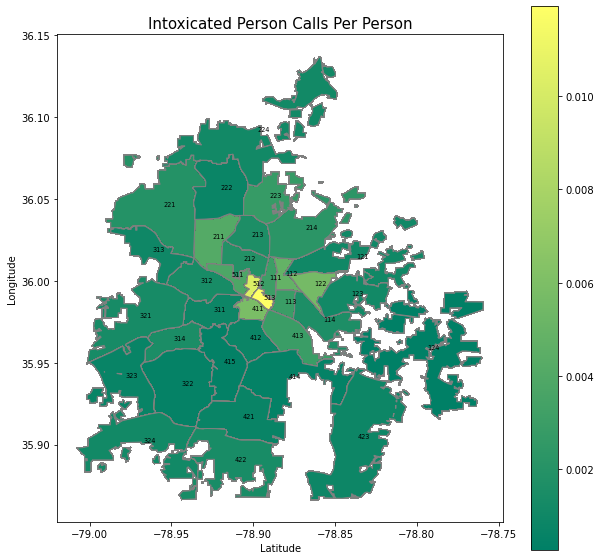

In [141]:
#Create choropleth of alcohol related nature calls per person
fig, ax = plt.subplots(figsize = (10,10))
calls_per_person.plot(column='intoxicated_callsperperson',
                                legend=True,
                                cmap="summer", ax=ax, aspect=1,
                                edgecolor="gray");
texts = []

for x, y, label in zip(policebeats_points.geometry.x, policebeats_points.geometry.y, policebeats_points["LAWBEAT"]):
    texts.append(plt.text(x, y, label, fontsize = 6.5, color='black'))

plt.title("Intoxicated Person Calls Per Person", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [142]:
#Print a table to show the alcohol proportions of each beat
nature_props = calls_per_person[['Beat', 'intoxicated_callsperperson', 'Intoxicated Person Call Count']]
nature_props = nature_props.groupby('Beat').mean()
nature_props.sort_values(by='intoxicated_callsperperson', inplace=True, ascending=False)
nature_props.head()

,intoxicated_callsperperson,Intoxicated Person Call Count
Beat,,
513,0.011285,19.417699
512,0.010225,17.059666
411,0.005833,18.941499
122,0.005514,17.785124
112,0.004834,15.015625


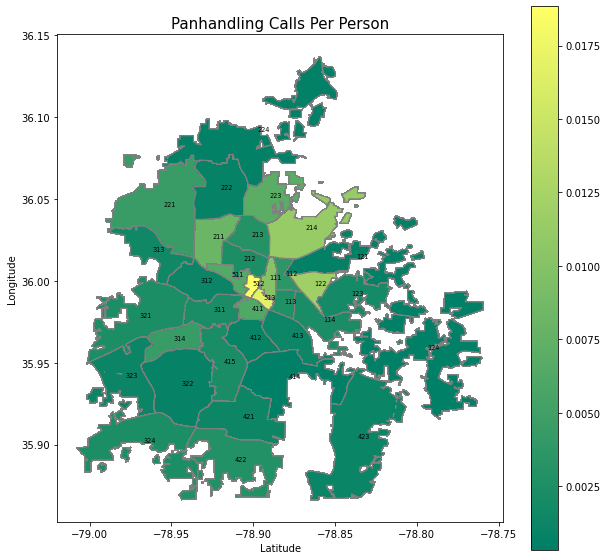

In [143]:
#Create choropleth of panhandling nature calls per person
fig, ax = plt.subplots(figsize = (10,10))
calls_per_person.plot(column='panhandling_callsperperson',
                                legend=True,
                                cmap="summer", ax=ax, aspect=1,
                                edgecolor="gray");

texts = []

for x, y, label in zip(policebeats_points.geometry.x, policebeats_points.geometry.y, policebeats_points["LAWBEAT"]):
    texts.append(plt.text(x, y, label, fontsize = 6.5))

plt.title("Panhandling Calls Per Person", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [144]:
#Print a table to show the panhandling proportions of each beat
pan_props = calls_per_person[['Beat', 'panhandling_callsperperson', 'Panhandling Call Count']]
pan_props = pan_props.groupby('Beat').mean()
pan_props.sort_values(by='panhandling_callsperperson', inplace=True, ascending=False)
pan_props.head()

,panhandling_callsperperson,Panhandling Call Count
Beat,,
512,0.018571,30.916468
513,0.016032,28.044248
122,0.011590,37.328512
214,0.011199,74.301852
111,0.009791,38.282548


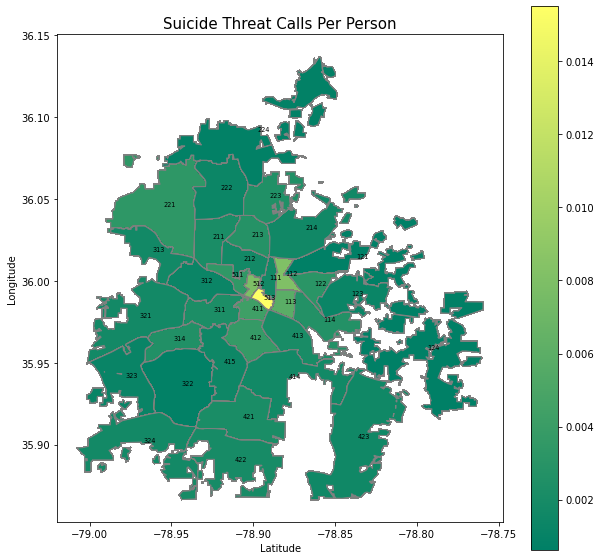

In [145]:
#Create choropleth of suicide nature calls per person
fig, ax = plt.subplots(figsize = (10,10))
calls_per_person.plot(column='suicide_callsperperson',
                                legend=True,
                                cmap="summer", ax=ax, aspect=1,
                                edgecolor="gray");

texts = []

for x, y, label in zip(policebeats_points.geometry.x, policebeats_points.geometry.y, policebeats_points["LAWBEAT"]):
    texts.append(plt.text(x, y, label, fontsize = 6.5))

plt.title("Suicide Threat Calls Per Person", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [146]:
#Print a table to show the suicide proportions of each beat
sui_props = calls_per_person[['Beat', 'suicide_callsperperson', 'Suicide Threat Call Count']]
sui_props = sui_props.groupby('Beat').mean()
sui_props.sort_values(by='suicide_callsperperson', inplace=True, ascending=False)
sui_props.head()

,suicide_callsperperson,Suicide Threat Call Count
Beat,,
513,0.014607,25.067257
512,0.007902,13.219570
112,0.007782,24.111979
113,0.005809,23.751708
411,0.004306,14.001828


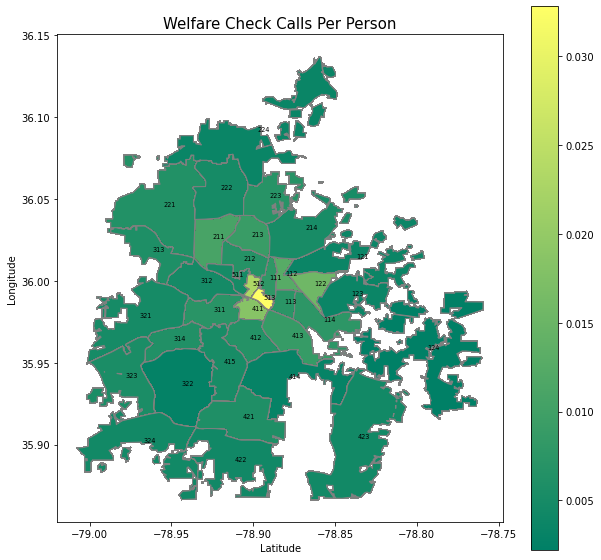

In [147]:
#Create choropleth of welfare nature calls per person
fig, ax = plt.subplots(figsize = (10,10))
calls_per_person.plot(column='welfare_callsperperson',
                                legend=True,
                                cmap="summer", ax=ax, aspect=1,
                                edgecolor="gray");

texts = []

for x, y, label in zip(policebeats_points.geometry.x, policebeats_points.geometry.y, policebeats_points["LAWBEAT"]):
    texts.append(plt.text(x, y, label, fontsize = 6.5))

plt.title("Welfare Check Calls Per Person", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [148]:
#Print a table to show the welfare proportions of each beat
nature_props = calls_per_person[['Beat', 'welfare_callsperperson', 'Welfare Check Call Count']]
nature_props = nature_props.groupby('Beat').mean()
nature_props.sort_values(by='welfare_callsperperson', inplace=True, ascending=False)
nature_props.head()

,welfare_callsperperson,Welfare Check Call Count
Beat,,
513,0.030964,53.182301
512,0.022911,38.205251
411,0.018384,59.842779
122,0.015380,49.772727
112,0.012600,39.138021


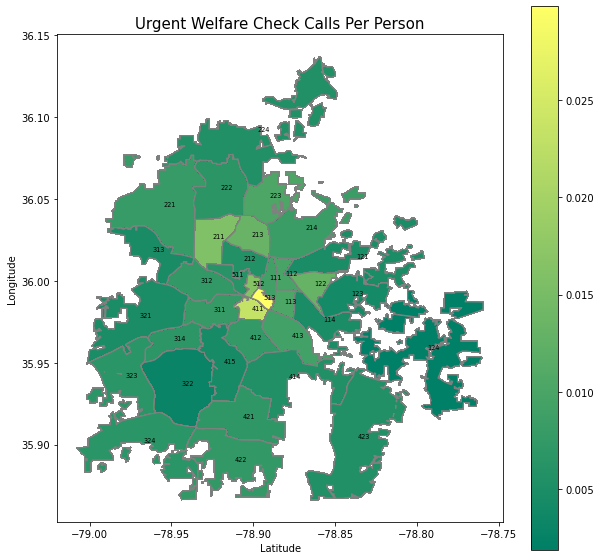

In [149]:
#Create choropleth of urgent welfare nature calls per person
fig, ax = plt.subplots(figsize = (10,10))
calls_per_person.plot(column='urgent_callsperperson',
                                legend=True,
                                cmap="summer", ax=ax, aspect=1,
                                edgecolor="gray");

texts = []

for x, y, label in zip(policebeats_points.geometry.x, policebeats_points.geometry.y, policebeats_points["LAWBEAT"]):
    texts.append(plt.text(x, y, label, fontsize = 6.5))

plt.title("Urgent Welfare Check Calls Per Person", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [150]:
#Print a table to show the urgent welfare proportions of each beat
nature_props = calls_per_person[['Beat', 'urgent_callsperperson', 'Urgent Welfare Check Call Count']]
nature_props = nature_props.groupby('Beat').mean()
nature_props.sort_values(by='urgent_callsperperson', inplace=True, ascending=False)
nature_props.head()

,urgent_callsperperson,Urgent Welfare Check Call Count
Beat,,
513,0.028300,49.014159
411,0.023211,75.650823
512,0.016389,27.470167
211,0.015677,102.735450
213,0.012988,65.960317


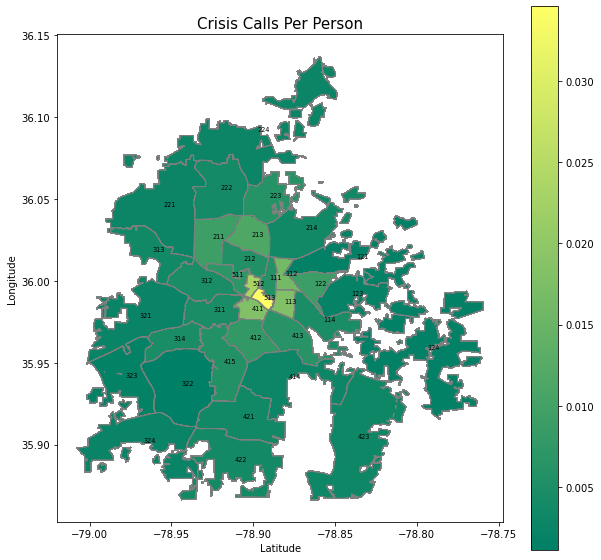

In [151]:
#Create choropleth of crisis nature calls per person
fig, ax = plt.subplots(figsize = (10,10))
calls_per_person.plot(column='crisis_callsperperson',
                                legend=True,
                                cmap="summer", ax=ax, aspect=1,
                                edgecolor="gray");

texts = []

for x, y, label in zip(policebeats_points.geometry.x, policebeats_points.geometry.y, policebeats_points["LAWBEAT"]):
    texts.append(plt.text(x, y, label, fontsize = 6.5))

plt.title("Crisis Calls Per Person", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [152]:
#Print a table to show the urgent welfare proportions of each beat
nature_props = calls_per_person[['Beat', 'crisis_callsperperson', 'Crisis Call Count']]
nature_props = nature_props.groupby('Beat').mean()
nature_props.sort_values(by='crisis_callsperperson', inplace=True, ascending=False)
nature_props.head()

,crisis_callsperperson,Crisis Call Count
Beat,,
513,0.032846,56.902655
512,0.022945,38.291169
411,0.018071,58.789762
113,0.017796,72.779043
112,0.015795,49.072917


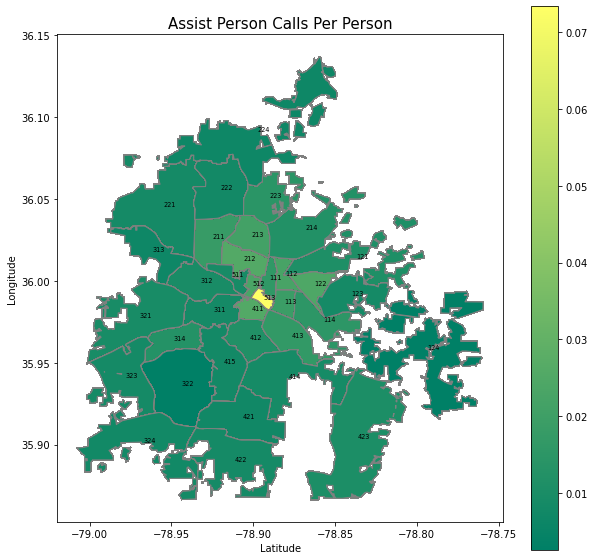

In [153]:
#Create choropleth of assist person nature calls per person
fig, ax = plt.subplots(figsize = (10,10))
calls_per_person.plot(column='assist_callsperperson',
                                legend=True,
                                cmap="summer", ax=ax, aspect=1,
                                edgecolor="gray");

texts = []

for x, y, label in zip(policebeats_points.geometry.x, policebeats_points.geometry.y, policebeats_points["LAWBEAT"]):
    texts.append(plt.text(x, y, label, fontsize = 6.5))

plt.title("Assist Person Calls Per Person", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [154]:
#Print a table to show the assist person proportions of each beat
nature_props = calls_per_person[['Beat', 'assist_callsperperson', 'Assist Person Call Count']]
nature_props = nature_props.groupby('Beat').mean()
nature_props.sort_values(by='assist_callsperperson', inplace=True, ascending=False)
nature_props.head()

,assist_callsperperson,Assist Person Call Count
Beat,,
513,0.069103,118.725664
411,0.025681,83.656307
212,0.025572,200.758427
122,0.024081,78.132231
512,0.023571,40.310263


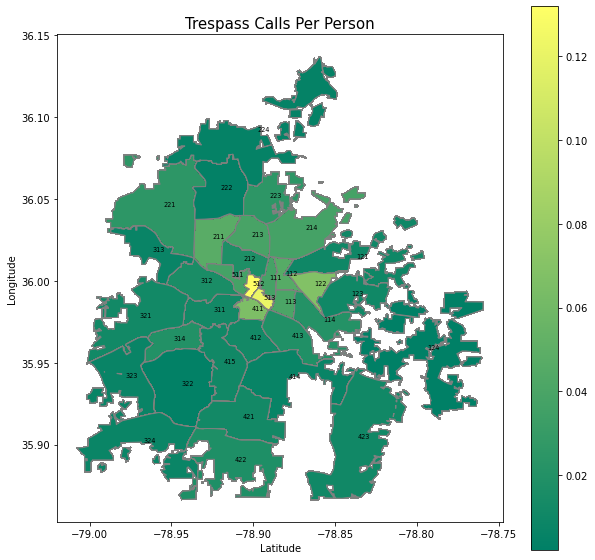

In [155]:
#Create choropleth of trespass calls per person
fig, ax = plt.subplots(figsize = (10,10))
calls_per_person.plot(column='trespass_callsperperson',
                                legend=True,
                                cmap="summer", ax=ax, aspect=1,
                                edgecolor="gray");

texts = []

for x, y, label in zip(policebeats_points.geometry.x, policebeats_points.geometry.y, policebeats_points["LAWBEAT"]):
    texts.append(plt.text(x, y, label, fontsize = 6.5))

plt.title("Trespass Calls Per Person", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [156]:
#Print a table to show the assist person proportions of each beat
nature_props = calls_per_person[['Beat', 'trespass_callsperperson', 'Trespass Call Count']]
nature_props = nature_props.groupby('Beat').mean()
nature_props.sort_values(by='trespass_callsperperson', inplace=True, ascending=False)
nature_props.head()

,trespass_callsperperson,Trespass Call Count
Beat,,
512,0.129992,216.171838
513,0.115817,200.571681
122,0.067050,216.297521
411,0.066095,214.528336
211,0.046752,305.928571


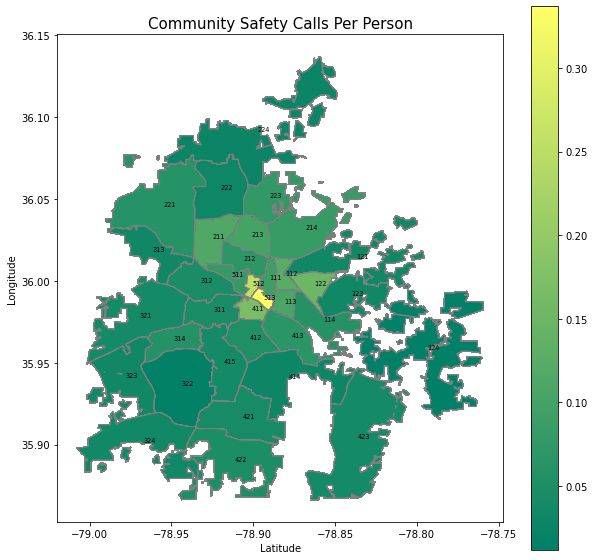

In [157]:
#Create choropleth of nature calls per person
fig, ax = plt.subplots(figsize = (10,10))
calls_per_person.plot(column='nature_callsperperson',
                                legend=True,
                                cmap="summer", ax=ax, aspect=1,
                                edgecolor="gray");

texts = []

for x, y, label in zip(policebeats_points.geometry.x, policebeats_points.geometry.y, policebeats_points["LAWBEAT"]):
    texts.append(plt.text(x, y, label, fontsize = 6.5))

plt.title("Community Safety Calls Per Person", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [158]:
#Print a table to show the community safety nature calls per person of each beat
nature_props = calls_per_person[['Beat', 'nature_callsperperson']]
nature_props = nature_props.groupby('Beat').mean()
nature_props.sort_values(by='nature_callsperperson', inplace=True, ascending=False)
nature_props.head()

,nature_callsperperson
Beat,
513,0.319541
512,0.252520
411,0.167769
122,0.148587
112,0.124682


In [159]:
#Filter calls_per_person for only community safety beats
calls_per_person_commsafe = calls_per_person.loc[calls_per_person['lbeat'].isin(commsafe_list)]

#Filter policebeats for only community safety beats
policebeats_commsafe = policebeats.loc[policebeats['LAWBEAT'].isin(commsafe_list)]

In [160]:
#Add centroid to policebeats_commsafe
policebeats_commsafe['rep'] = policebeats_commsafe['geometry'].representative_point()
policebeats_commsafe_points=policebeats_commsafe.copy()
policebeats_commsafe_points.set_geometry("rep", inplace = True)
policebeats_commsafe_points=policebeats_commsafe_points.drop(columns=['geometry'])
policebeats_commsafe_points=policebeats_commsafe_points.rename(columns= {'rep':'geometry'})

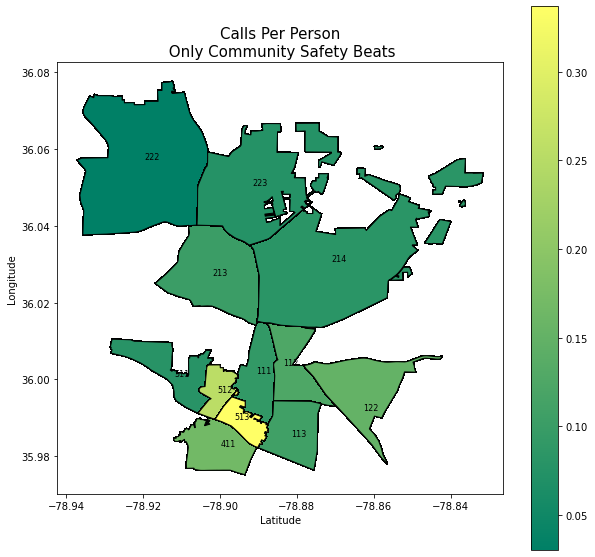

In [161]:
#Plot choropleth map for nature calls per person in community safety beats
fig, ax = plt.subplots(figsize = (10,10))
calls_per_person_commsafe.plot(column='nature_callsperperson',
                                legend=True,
                                cmap="summer", ax=ax, aspect=1,
                                edgecolor="black");

texts = []

for x, y, label in zip(policebeats_commsafe_points.geometry.x, policebeats_commsafe_points.geometry.y, policebeats_commsafe_points["LAWBEAT"]):
    texts.append(plt.text(x, y, label, fontsize = 8))
               
plt.title("Calls Per Person\n Only Community Safety Beats", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

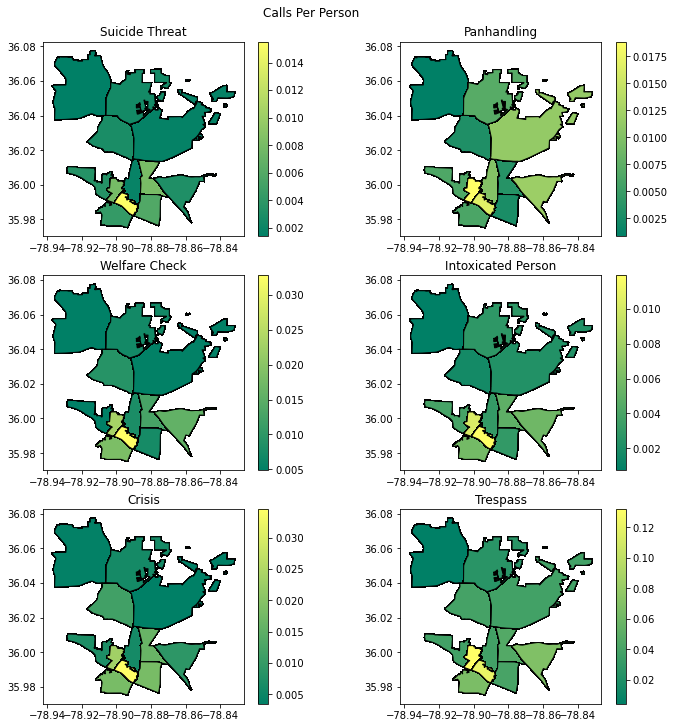

In [162]:
#Plot subplots of calls per person
fig = plt.figure(constrained_layout=True, figsize=(10, 10))

gridspan = fig.add_gridspec(1, 1)
gs = GridSpec(3, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 1])
ax1.title.set_text('Suicide Threat')
ax2.title.set_text('Panhandling')
ax3.title.set_text('Welfare Check')
ax4.title.set_text('Intoxicated Person')
ax5.title.set_text('Crisis')
ax6.title.set_text('Trespass')

# Set figure title
fig.suptitle("Calls Per Person")

#Plot subplots
calls_per_person_commsafe.plot(column='suicide_callsperperson',
                                legend=True,
                                cmap="summer", ax=ax1, aspect=1, edgecolor='black');

calls_per_person_commsafe.plot(column='panhandling_callsperperson',
                                legend=True,
                                cmap="summer", ax=ax2, aspect=1, edgecolor='black');

calls_per_person_commsafe.plot(column='welfare_callsperperson',
                                legend=True,
                                cmap="summer", ax=ax3, aspect=1, edgecolor='black');

calls_per_person_commsafe.plot(column='intoxicated_callsperperson',
                                legend=True,
                                cmap="summer", ax=ax4, aspect=1, edgecolor='black');

calls_per_person_commsafe.plot(column='crisis_callsperperson',
                                legend=True,
                                cmap="summer", ax=ax5, aspect=1, edgecolor='black');

calls_per_person_commsafe.plot(column='trespass_callsperperson',
                                legend=True,
                                cmap="summer", ax=ax6, aspect=1, edgecolor='black');

plt.show()

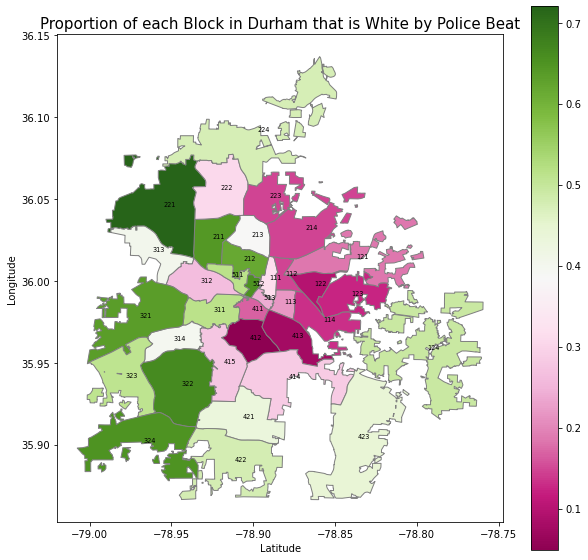

In [163]:
#Plot the race data by beat
fig, ax = plt.subplots(figsize = (10,10))
raceineachbeat.plot(column='propwhite',
                                legend=True,
                                cmap="PiYG", ax=ax, aspect=1, edgecolor='gray');

texts = []

for x, y, label in zip(raceineachbeat_points.geometry.x, raceineachbeat_points.geometry.y, raceineachbeat_points["lawbeat"]):
    texts.append(plt.text(x, y, label, fontsize = 6.5))

plt.title("Proportion of each Block in Durham that is White by Police Beat", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [164]:
#Print the five beats with the highest proportion of white people
raceineachbeatprops = raceineachbeat[['lawbeat', 'propwhite']]
raceineachbeatprops.sort_values(by='propwhite', inplace=True, ascending=False)
raceineachbeatprops.head()

,lawbeat,propwhite
12,221,0.720148
21,322,0.665034
33,512,0.653706
23,324,0.650155
8,211,0.643490


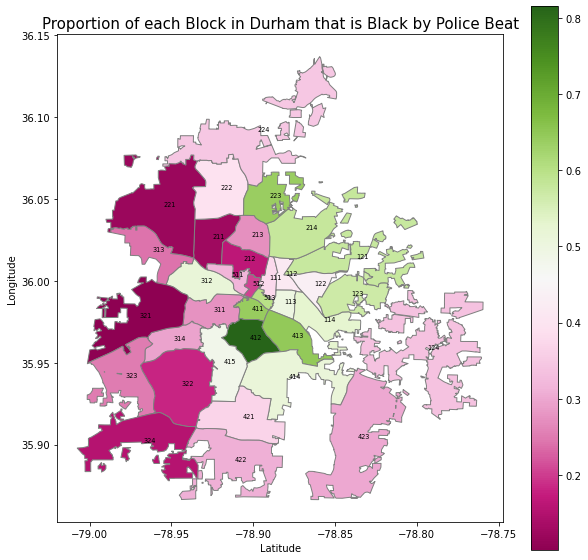

In [165]:
#Plot the race data by beat
fig, ax = plt.subplots(figsize = (10,10))
raceineachbeat.plot(column='propblack',
                                legend=True,
                                cmap="PiYG", ax=ax, aspect=1, edgecolor='gray');

texts = []

for x, y, label in zip(raceineachbeat_points.geometry.x, raceineachbeat_points.geometry.y, raceineachbeat_points["lawbeat"]):
    texts.append(plt.text(x, y, label, fontsize = 6.5))

plt.title("Proportion of each Block in Durham that is Black by Police Beat", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [166]:
#Print the five beats with the highest proportion of Black people
raceineachbeatprops = raceineachbeat[['lawbeat', 'propblack']]
raceineachbeatprops.sort_values(by='propblack', inplace=True, ascending=False)
raceineachbeatprops.head()

,lawbeat,propblack
25,412,0.815303
26,413,0.647255
24,411,0.642134
14,223,0.638283
34,513,0.598092


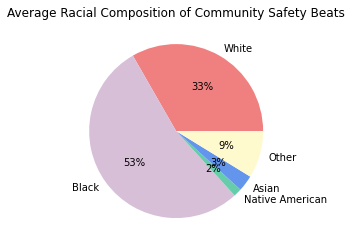

In [295]:
#Filter out raceineachbeat 
commsafe_race_props = raceineachbeat.loc[raceineachbeat['lawbeat'].isin(commsafe_list)]

#Create new data frame with just proportions for community safety beats
commsafe_race_props = commsafe_race_props[['propwhite', 'propblack', 'propnativeamerican', 'propasian', 'propother']]

#Change column names
commsafe_race_props.rename(columns = {'propwhite':'White', 'propblack':'Black', 'propnativeamerican':'Native American', 'propasian':'Asian', 'propother':'Other'}, inplace = True)

#Pie chart for justprop
commsafe_race_props.mean().plot.pie(ylabel='', title='Average Racial Composition of Community Safety Beats', autopct='%1.0f%%', colors=['lightcoral', 'thistle', 'mediumaquamarine', 'cornflowerblue','lemonchiffon', 'lavender', 'mediumpurple', 'mistyrose']);

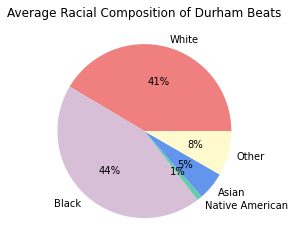

In [296]:
#Create new data frame with just proportions for community safety beats
race_props = raceineachbeat[['propwhite', 'propblack', 'propnativeamerican', 'propasian', 'propother']]

#Change column names
race_props.rename(columns = {'propwhite':'White', 'propblack':'Black', 'propnativeamerican':'Native American', 'propasian':'Asian', 'propother':'Other'}, inplace = True)

#Pie chart for justprop
race_props.mean().plot.pie(ylabel='', title='Average Racial Composition of Durham Beats', autopct='%1.0f%%', colors=['lightcoral', 'thistle', 'mediumaquamarine', 'cornflowerblue','lemonchiffon', 'lavender', 'mediumpurple', 'mistyrose']);

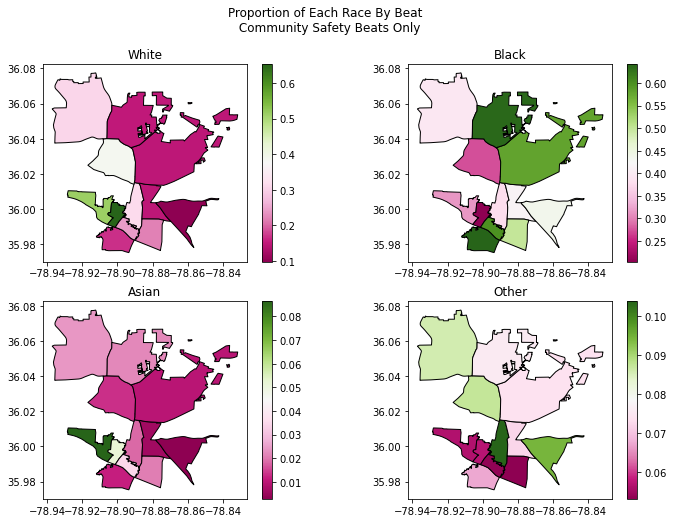

In [171]:
#Filter out raceineachbeat 
raceineachbeat_comsafe = raceineachbeat.loc[raceineachbeat['lawbeat'].isin(commsafe_list)]

#Plot subplots of racial data
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

ax11 = axs[0][0]
ax12 = axs[0][1]
ax21 = axs[1][0]
ax22 = axs[1][1]
ax11.title.set_text('White')
ax12.title.set_text('Black')
ax21.title.set_text('Asian')
ax22.title.set_text('Other')

# Set figure title
fig.suptitle("Proportion of Each Race By Beat \n Community Safety Beats Only")

#Plot subplots
raceineachbeat_comsafe.plot(column='propwhite',
                                legend=True,
                                cmap="PiYG", ax=ax11, aspect=1, edgecolor='black');

raceineachbeat_comsafe.plot(column='propblack',
                                legend=True,
                                cmap="PiYG", ax=ax12, aspect=1, edgecolor='black');

raceineachbeat_comsafe.plot(column='propasian',
                                legend=True,
                                cmap="PiYG", ax=ax21, aspect=1, edgecolor='black');

raceineachbeat_comsafe.plot(column='propother',
                                legend=True,
                                cmap="PiYG", ax=ax22, aspect=1, edgecolor='black');

plt.show()

In [172]:
#Load in Hispanic Census Data
#Data is from 2020 US Census Bureau filtered by census blocks for Durham
hispanicdata = pd.read_csv('/Users/sadiesheridan/Desktop/Hispanic Data/DECENNIALPL2020.P2_data_with_overlays_2022-06-09T143343.csv', skiprows =1)

#Change the geoid to a string 
hispanicdata['GEOID20'] = hispanicdata['id'].str[-15:]
hispanicdata.drop('id', axis=1, inplace=True)
hispanicdata.drop(hispanicdata.iloc[:, 4:74], inplace = True, axis = 1)

#Rename column names
hispanicdata.columns = hispanicdata.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
hispanicdata.columns = hispanicdata.columns.str.replace('[#,@,&,!]', '')
hispanicdata.columns = hispanicdata.columns.str.replace('[:]', '_')
hispanicdata.rename(columns = {'total_':'total', 'total_not_hispanic_or_latino_':'total_not_hispanic_or_latino'}, inplace = True)

#Putting Hispanic data into the police beat and block data
hispanicdata = pd.merge(cblockDurhamBeats, hispanicdata, left_on='GEOID20', right_on='geoid20')
hispanicdata = hispanicdata.groupby('Beat', as_index=False).sum()
hispanicdata = pd.merge(hispanicdata, policebeats, left_on='Beat', right_on='LAWBEAT')
hispanicdata = hispanicdata.to_crs("EPSG:4326")

#Add column for proportion of Hispanic people
hispanicdata['prophispanic']= hispanicdata['total_hispanic_or_latino'] / hispanicdata['total']
hispanicdata['propnothispanic'] = hispanicdata['total_not_hispanic_or_latino'] / hispanicdata['total']

hispanicdata.head()

,Beat,ALAND20,AWATER20,total,total_hispanic_or_latino,total_not_hispanic_or_latino,LAWBEAT,geometry,OBJECTID,PERIMETER,STATUS,CONTIGUOUS,LAWDIST,CAD,GIS_DataA1,ShapeSTAre,ShapeSTLen,LBeat,id,center,prophispanic,propnothispanic
0,111,1885019,0,3949,1130,2819,111,"POLYGON ((-78.89039 36.01517, -78.89038 36.015...",50,28608.800781,I,yes,D1,111,None,2.010252e+07,28608.799743,111,0,POINT (-78.88998 36.00096),0.286148,0.713852
1,112,1863048,0,3083,1366,1717,112,"POLYGON ((-78.88787 36.01473, -78.88734 36.014...",51,26265.849609,I,yes,D1,112,None,2.079934e+07,26265.852604,112,1,POINT (-78.88072 36.00323),0.443075,0.556925
2,113,2056983,1025,4094,1038,3056,113,"POLYGON ((-78.87372 35.99369, -78.87458 35.991...",62,20667.539062,I,yes,D1,113,None,2.159195e+07,20667.538873,113,2,POINT (-78.88085 35.98633),0.253542,0.746458
3,114,5975063,40919,5631,1756,3875,114,"MULTIPOLYGON (((-78.84053 35.95436, -78.84021 ...",65,53321.980469,I,yes,D1,114,None,6.103382e+07,53321.974873,114,3,POINT (-78.85704 35.97516),0.311845,0.688155
4,121,12440369,123268,8025,1803,6222,121,"MULTIPOLYGON (((-78.80746 35.99706, -78.80746 ...",38,14495.120117,I,no,D1,121,None,7.008533e+06,14495.120026,121,4,POINT (-78.83717 36.01364),0.224673,0.775327


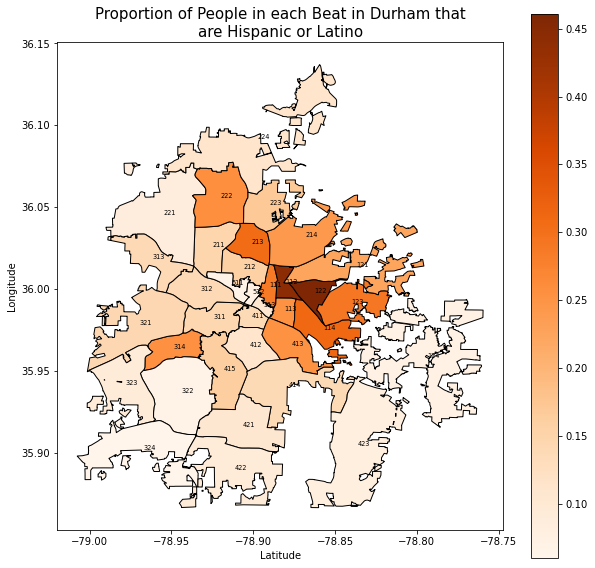

In [173]:
#Plot choropleth map with Hispanic and beat data
fig, ax = plt.subplots(figsize = (10,10))
hispanicdata.plot(column='prophispanic',
                                legend=True,
                                cmap="Oranges", ax=ax, aspect=1,
                                edgecolor='black');

texts = []

for x, y, label in zip(policebeats_points.geometry.x, policebeats_points.geometry.y, policebeats_points["LAWBEAT"]):
    texts.append(plt.text(x, y, label, fontsize = 6.5))

plt.title("Proportion of People in each Beat in Durham that\nare Hispanic or Latino", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [250]:
#Filter out hispanic data for community safety beats
commsafe_hispanic = hispanicdata.loc[hispanicdata['LAWBEAT'].isin(commsafe_list)]

#Filter out for group 1
group1_hispanic = hispanicdata.loc[hispanicdata['LAWBEAT'].isin(group1_list)]

#Filter out for group2
group2_hispanic = hispanicdata.loc[hispanicdata['LAWBEAT'].isin(group2_list)]

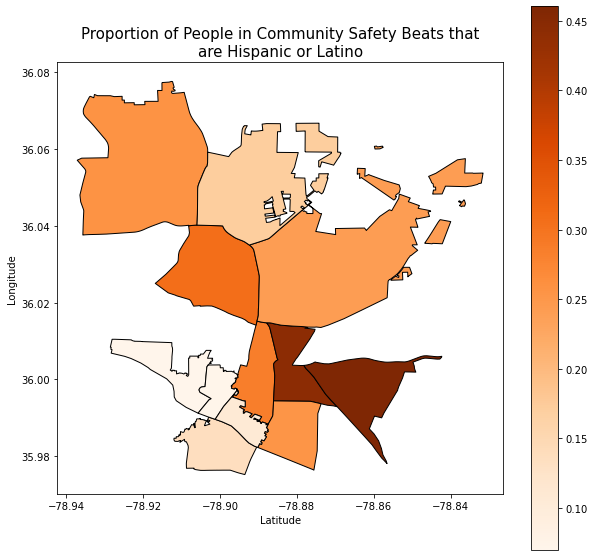

In [175]:
#Plot choropleth map with Hispanic and beat data
fig, ax = plt.subplots(figsize = (10,10))
commsafe_hispanic.plot(column='prophispanic',
                                legend=True,
                                cmap="Oranges", ax=ax, aspect=1,
                                edgecolor='black');

plt.title("Proportion of People in Community Safety Beats that\nare Hispanic or Latino", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

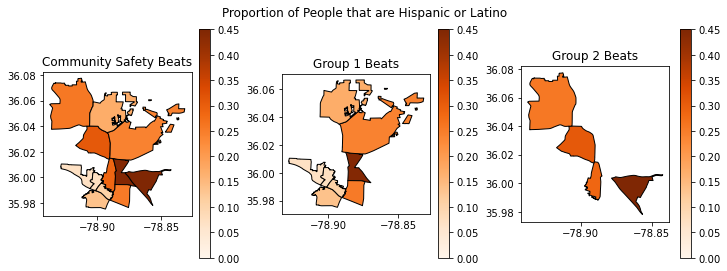

In [254]:
#Plot subplots of householdincome
fig = plt.figure(constrained_layout=True, figsize=(10, 10))

vmin, vmax = 0, 0.45

gridspan = fig.add_gridspec(1, 1)
gs = GridSpec(3, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax1.title.set_text('Community Safety Beats')
ax2.title.set_text('Group 1 Beats')
ax3.title.set_text('Group 2 Beats')

# Set figure title
fig.suptitle("Proportion of People that are Hispanic or Latino")

#Plot subplots
commsafe_hispanic.plot(column='prophispanic',
                                legend=True,
                                cmap="Oranges", ax=ax1, vmin=vmin, vmax=vmax, aspect=1, edgecolor='black');

group1_hispanic.plot(column='prophispanic',
                                legend=True,
                                cmap="Oranges", ax=ax2, vmin=vmin, vmax=vmax, aspect=1, edgecolor='black');

group2_hispanic.plot(column='prophispanic',
                                legend=True,
                                cmap="Oranges", ax=ax3, vmin=vmin, vmax=vmax, aspect=1, edgecolor='black');

plt.show()

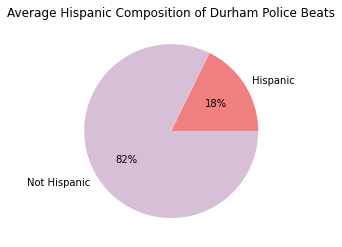

In [297]:
#Create new data frame that is just proportions for all of Durham
propDurham_hispanic = hispanicdata[['prophispanic', 'propnothispanic']]

#Change column names
propDurham_hispanic.rename(columns = {'prophispanic':'Hispanic', 'propnothispanic':'Not Hispanic'}, inplace = True)

#Pie chart for proportion of hispanic/non-hispanic in Durham
propDurham_hispanic.mean().plot.pie(ylabel='', title='Average Hispanic Composition of Durham Police Beats', autopct='%1.0f%%', colors=['lightcoral', 'thistle', 'mediumaquamarine', 'cornflowerblue','lemonchiffon', 'lavender', 'mediumpurple', 'mistyrose']);

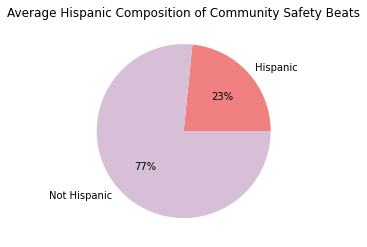

In [298]:
#Create new data frame that is just proportions for com safe
propComSafe_hispanic = commsafe_hispanic[['prophispanic', 'propnothispanic']]

#Change column names
propComSafe_hispanic.rename(columns = {'prophispanic':'Hispanic', 'propnothispanic':'Not Hispanic'}, inplace = True)

#Pie chart for proportion of hispanic/non-hispanic in Durham
propComSafe_hispanic.mean().plot.pie(ylabel='', title='Average Hispanic Composition of Community Safety Beats', autopct='%1.0f%%', colors=['lightcoral', 'thistle', 'mediumaquamarine', 'cornflowerblue','lemonchiffon', 'lavender', 'mediumpurple', 'mistyrose']);

In [185]:
#Load in block group shapefile from 2020 US Census Bureau
ncblockgroupmap = gpd.read_file('/Users/sadiesheridan/Desktop/2020BlockGroup/tl_2020_37_bg.shp')
ncblockgroupmap = ncblockgroupmap.to_crs("EPSG:4326")

#Filter nc map for Durham county
durhamblockgroupmap = ncblockgroupmap[ncblockgroupmap["COUNTYFP"]=="063"]
durhamblockgroupmap.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
200,37,063,001801,3,370630018013,Block Group 3,G5030,S,6464902,1821762,+36.0484559,-078.7914777,"POLYGON ((-78.82078 36.04266, -78.81975 36.043..."
201,37,063,001708,4,370630017084,Block Group 4,G5030,S,3576476,162732,+36.0686265,-078.8813769,"POLYGON ((-78.89638 36.05947, -78.89558 36.060..."
202,37,063,001601,6,370630016016,Block Group 6,G5030,S,853369,71621,+36.1115132,-078.8723335,"POLYGON ((-78.90575 36.13901, -78.90547 36.139..."
203,37,063,002037,2,370630020372,Block Group 2,G5030,S,5587220,20203,+35.8759021,-078.8446003,"POLYGON ((-78.86797 35.88224, -78.86712 35.882..."
204,37,063,002038,2,370630020382,Block Group 2,G5030,S,10845441,55347,+35.9125582,-078.8313847,"POLYGON ((-78.85279 35.90356, -78.85278 35.904..."


In [186]:
#Assign each census block to a police beat with for loop
#Uses 2020 block groups from US Census Bureau
cblockIndexToBeat = {}
sIndex = policebeats.sindex

for cblock_ind in durhamblockgroupmap.index:
    cblock_geom = durhamblockgroupmap.loc[cblock_ind]["geometry"]
    possibleBeatMatches = list(sIndex.intersection(cblock_geom.bounds))
    matched = False

    if len(possibleBeatMatches) > 0:
        possibleMatches = policebeats.iloc[possibleBeatMatches]
        intersectingAreas = possibleMatches.intersection(cblock_geom).area
        intersectingAreas /= cblock_geom.area
        police_beat_index = intersectingAreas.idxmax()
        maxIntersection = intersectingAreas.max()
    ##########
        if maxIntersection < 0.1:
            continue
    ##########
        if maxIntersection > 0:
            cblockIndexToBeat[cblock_ind] = policebeats.loc[police_beat_index]['LAWBEAT']
            matched = True

cblockDurhamBeatsbg = ncblockgroupmap[ncblockgroupmap.index.isin(cblockIndexToBeat)]
cblockDurhamBeatsbg['Beat'] = cblockDurhamBeatsbg.index.map(lambda ii: cblockIndexToBeat[ii])
warnings.filterwarnings('ignore')

In [209]:
#Load in income data
#Taken from 2020 US Census Bureau in block groups for Durham
householdincome = pd.read_csv('/Users/sadiesheridan/Downloads/householdincome/ACSDT5Y2020.B19001_data_with_overlays_2022-04-26T111027.csv', skiprows =1)

#Change the geoid to a string 
householdincome['GEOID20'] = householdincome['id'].str[-12:]
householdincome.drop('id', axis=1, inplace=True)

#Rename column names
householdincome.columns = householdincome.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
householdincome.columns = householdincome.columns.str.replace('[#,@,&,!]', '')
householdincome.columns = householdincome.columns.str.replace('[:]', '_')
householdincome.rename(columns = {'Estimate!!Total:	':'total'}, inplace = True)

#Putting data into the police beat and block data
householdincome = pd.merge(cblockDurhamBeatsbg, householdincome, left_on='GEOID', right_on='geoid20')
householdincome = householdincome.groupby('Beat', as_index=False).sum()

#Create larger income subsets
householdincome['0to25']= householdincome['estimatetotal_less_than_$10000'] + householdincome['estimatetotal_$10000_to_$14999'] + householdincome['estimatetotal_$15000_to_$19999'] + householdincome['estimatetotal_$20000_to_$24999']
householdincome['25to50']= householdincome['estimatetotal_$25000_to_$29999'] + householdincome['estimatetotal_$30000_to_$34999'] + householdincome['estimatetotal_$35000_to_$39999'] + householdincome['estimatetotal_$40000_to_$44999'] + householdincome['estimatetotal_$45000_to_$49999']
householdincome['50to75']= householdincome['estimatetotal_$50000_to_$59999'] + householdincome['estimatetotal_$60000_to_$74999']
householdincome['75to100']= householdincome['estimatetotal_$75000_to_$99999']
householdincome['100plus']= householdincome['estimatetotal_$100000_to_$124999'] + householdincome['estimatetotal_$125000_to_$149999'] + householdincome['estimatetotal_$150000_to_$199999'] + householdincome['estimatetotal_$200000_or_more']

#Add proportion columns
householdincome['prop_0to25']= householdincome['0to25'] / householdincome['estimatetotal_']
householdincome['prop_25to50']= householdincome['25to50'] / householdincome['estimatetotal_']
householdincome['prop_50to75']= householdincome['50to75'] / householdincome['estimatetotal_']
householdincome['prop_75to100']= householdincome['75to100'] / householdincome['estimatetotal_']
householdincome['prop_100plus']= householdincome['100plus'] / householdincome['estimatetotal_']

#Merge with policebeats shapefile on beat
householdincome = pd.merge(householdincome, policebeats, left_on='Beat', right_on='LAWBEAT')
householdincome = householdincome.to_crs("EPSG:4326")

householdincome.head()

,Beat,ALAND,AWATER,estimatetotal_,margin_of_errortotal_,estimatetotal_less_than_$10000,margin_of_errortotal_less_than_$10000,estimatetotal_$10000_to_$14999,margin_of_errortotal_$10000_to_$14999,estimatetotal_$15000_to_$19999,margin_of_errortotal_$15000_to_$19999,estimatetotal_$20000_to_$24999,margin_of_errortotal_$20000_to_$24999,estimatetotal_$25000_to_$29999,margin_of_errortotal_$25000_to_$29999,estimatetotal_$30000_to_$34999,margin_of_errortotal_$30000_to_$34999,estimatetotal_$35000_to_$39999,margin_of_errortotal_$35000_to_$39999,estimatetotal_$40000_to_$44999,margin_of_errortotal_$40000_to_$44999,estimatetotal_$45000_to_$49999,margin_of_errortotal_$45000_to_$49999,estimatetotal_$50000_to_$59999,margin_of_errortotal_$50000_to_$59999,estimatetotal_$60000_to_$74999,margin_of_errortotal_$60000_to_$74999,estimatetotal_$75000_to_$99999,margin_of_errortotal_$75000_to_$99999,estimatetotal_$100000_to_$124999,margin_of_errortotal_$100000_to_$124999,estimatetotal_$125000_to_$149999,margin_of_errortotal_$125000_to_$149999,estimatetotal_$150000_to_$199999,margin_of_errortotal_$150000_to_$199999,estimatetotal_$200000_or_more,margin_of_errortotal_$200000_or_more,0to25,25to50,50to75,75to100,100plus,prop_0to25,prop_25to50,prop_50to75,prop_75to100,prop_100plus,LAWBEAT,geometry,OBJECTID,PERIMETER,STATUS,CONTIGUOUS,LAWDIST,CAD,GIS_DataA1,ShapeSTAre,ShapeSTLen,LBeat,id,center
0,111,1868373,0,1482,455,174,168,158,139,46,78,82,114,107,124,55,90,81,105,75,98,128,151,85,102,132,135,105,101,60,104,78,132,51,83,65,90,460,446,217,105,254,0.310391,0.300945,0.146424,0.070850,0.171390,111,"POLYGON ((-78.89039 36.01517, -78.89038 36.015...",50,28608.800781,I,yes,D1,111,None,2.010252e+07,28608.799743,111,0,POINT (-78.88998 36.00096)
1,112,989493,0,822,228,143,126,25,36,52,74,104,108,115,114,67,63,10,28,0,26,57,83,64,68,0,26,72,115,8,26,64,79,33,53,8,24,324,249,64,72,113,0.394161,0.302920,0.077859,0.087591,0.137470,112,"POLYGON ((-78.88787 36.01473, -78.88734 36.014...",51,26265.849609,I,yes,D1,112,None,2.079934e+07,26265.852604,112,1,POINT (-78.88072 36.00323)
2,113,1098114,1025,1084,411,59,86,150,176,7,38,24,56,280,211,140,167,7,39,67,95,35,58,115,149,54,82,58,85,11,43,36,62,21,44,20,52,240,529,169,58,88,0.221402,0.488007,0.155904,0.053506,0.081181,113,"POLYGON ((-78.87372 35.99369, -78.87458 35.991...",62,20667.539062,I,yes,D1,113,None,2.159195e+07,20667.538873,113,2,POINT (-78.88085 35.98633)
3,114,8429033,57311,2694,1073,266,283,133,197,107,196,267,365,126,174,281,307,175,303,61,141,160,242,355,465,92,165,336,426,260,292,61,154,8,91,6,88,773,803,447,336,335,0.286934,0.298070,0.165924,0.124722,0.124350,114,"MULTIPOLYGON (((-78.84053 35.95436, -78.84021 ...",65,53321.980469,I,yes,D1,114,None,6.103382e+07,53321.974873,114,3,POINT (-78.85704 35.97516)
4,121,19723564,210604,3674,1375,91,185,177,293,266,433,106,208,22,128,138,226,243,308,195,344,150,247,344,471,366,395,758,657,449,489,168,247,165,289,36,133,640,748,710,758,818,0.174197,0.203593,0.193250,0.206315,0.222646,121,"MULTIPOLYGON (((-78.80746 35.99706, -78.80746 ...",38,14495.120117,I,no,D1,121,None,7.008533e+06,14495.120026,121,4,POINT (-78.83717 36.01364)


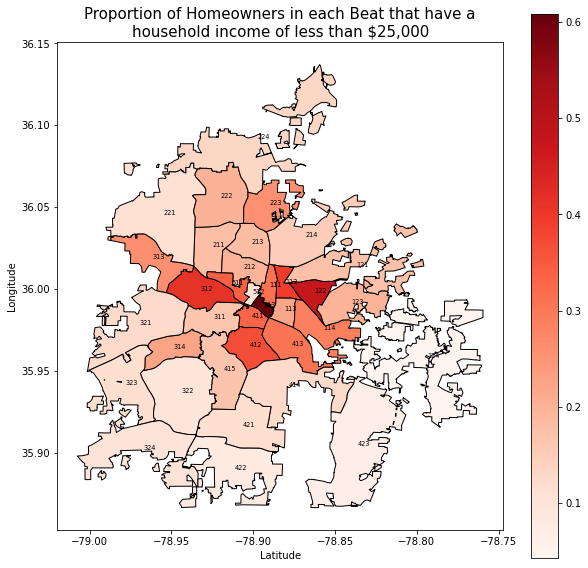

In [217]:
#Plot choropleth map with merged data
fig, ax = plt.subplots(figsize = (10,10))
householdincome.plot(column='prop_0to25',
                                legend=True,
                                cmap="Reds", ax=ax, aspect=1, edgecolor = 'black');

texts = []

for x, y, label in zip(policebeats_points.geometry.x, policebeats_points.geometry.y, policebeats_points["LAWBEAT"]):
    texts.append(plt.text(x, y, label, fontsize = 6.5))

plt.title("Proportion of Homeowners in each Beat that have a\nhousehold income of less than $25,000", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [214]:
#Print the five beats with the highest proportion of households under 25000
under25_table = householdincome[['LAWBEAT', 'prop_0to25']]
under25_table.sort_values(by='prop_0to25', inplace=True, ascending=False)
under25_table.head()

,LAWBEAT,prop_0to25
34,513,0.607843
5,122,0.477477
17,312,0.412181
1,112,0.394161
25,412,0.370487


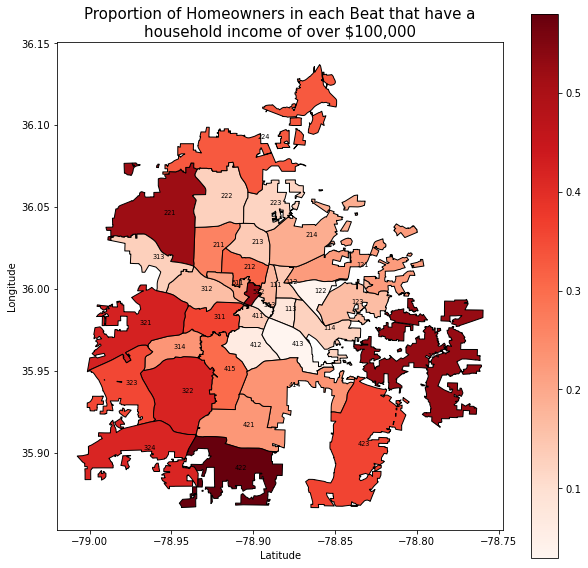

In [218]:
#Plot choropleth map with merged data
fig, ax = plt.subplots(figsize = (10,10))
householdincome.plot(column='prop_100plus',
                                legend=True,
                                cmap="Reds", ax=ax, aspect=1, edgecolor = 'black');

texts = []

for x, y, label in zip(policebeats_points.geometry.x, policebeats_points.geometry.y, policebeats_points["LAWBEAT"]):
    texts.append(plt.text(x, y, label, fontsize = 6.5))

plt.title("Proportion of Homeowners in each Beat that have a\nhousehold income of over $100,000", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [215]:
#Print the five beats with the highest proportion of households over 100000
over100_table = householdincome[['LAWBEAT', 'prop_100plus']]
over100_table.sort_values(by='prop_100plus', inplace=True, ascending=False)
over100_table.head()

,LAWBEAT,prop_100plus
30,422,0.579115
7,124,0.525636
33,512,0.523649
12,221,0.518035
20,321,0.423784


In [216]:
#Filter for community safety beats
commsafe_householdincome = householdincome.loc[householdincome['LAWBEAT'].isin(commsafe_list)]

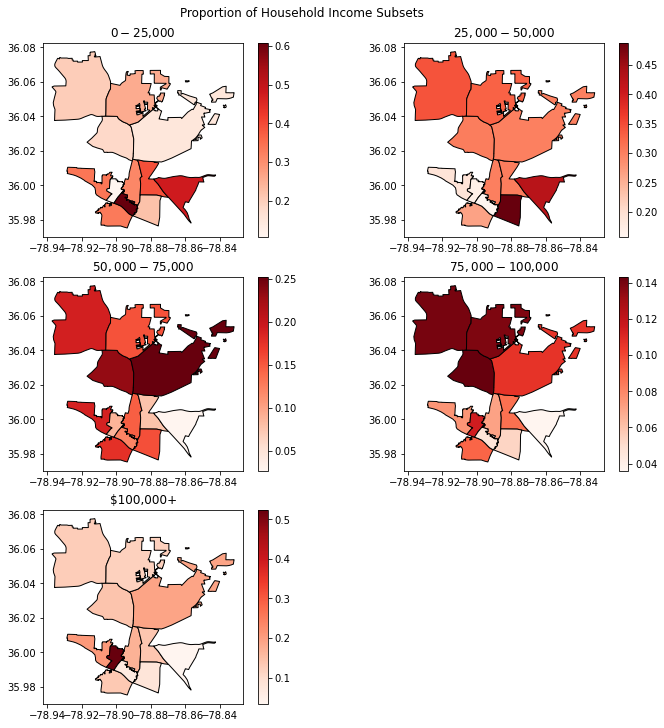

In [220]:
#Plot subplots of householdincome
fig = plt.figure(constrained_layout=True, figsize=(10, 10))

gridspan = fig.add_gridspec(1, 1)
gs = GridSpec(3, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, 0])
ax1.title.set_text('$0-$25,000')
ax2.title.set_text('$25,000-$50,000')
ax3.title.set_text('$50,000-$75,000')
ax4.title.set_text('$75,000-$100,000')
ax5.title.set_text('$100,000+')

# Set figure title
fig.suptitle("Proportion of Household Income Subsets")

#Plot subplots
commsafe_householdincome.plot(column='prop_0to25',
                                legend=True,
                                cmap="Reds", ax=ax1, aspect=1, edgecolor='black');

commsafe_householdincome.plot(column='prop_25to50',
                                legend=True,
                                cmap="Reds", ax=ax2, aspect=1, edgecolor='black');

commsafe_householdincome.plot(column='prop_50to75',
                                legend=True,
                                cmap="Reds", ax=ax3, aspect=1, edgecolor='black');

commsafe_householdincome.plot(column='prop_75to100',
                                legend=True,
                                cmap="Reds", ax=ax4, aspect=1, edgecolor='black');

commsafe_householdincome.plot(column='prop_100plus',
                                legend=True,
                                cmap="Reds", ax=ax5, aspect=1, edgecolor='black');

plt.show()

In [230]:
#Load in ncblock data from 2010 US Census Bureau
ncblock2010 = gpd.read_file('/Users/sadiesheridan/Desktop/tl_2010_37_tabblock10/tl_2010_37_tabblock10.shp')

#Set the crs for the 2010 block data
ncblock2010 = ncblock2010.to_crs("EPSG:4326")

#Filter out for blocks only in Durham
durhamblock2010 = ncblock2010[ncblock2010["COUNTYFP10"]=="063"]

In [231]:
#Assign 2010 blocks to current police beats from US Census Bureau
cblockIndexToBeat10 = {}
sIndex = policebeats.sindex

for cblock_ind in durhamblock2010.index:
    cblock_geom = durhamblock2010.loc[cblock_ind]["geometry"]
    possibleBeatMatches = list(sIndex.intersection(cblock_geom.bounds))
    matched = False

    if len(possibleBeatMatches) > 0:
        possibleMatches = policebeats.iloc[possibleBeatMatches]
        intersectingAreas = possibleMatches.intersection(cblock_geom).area
        intersectingAreas /= cblock_geom.area
        police_beat_index = intersectingAreas.idxmax()
        maxIntersection = intersectingAreas.max()
    ##########
        if maxIntersection < 0.1:
            continue
    ##########
        if maxIntersection > 0:
            cblockIndexToBeat10[cblock_ind] = policebeats.loc[police_beat_index]['LAWBEAT']
            matched = True

cblockDurhamBeats10 = ncblock2010[ncblock2010.index.isin(cblockIndexToBeat10)]
cblockDurhamBeats10['Beat'] = cblockDurhamBeats10.index.map(lambda ii: cblockIndexToBeat10[ii])

warnings.filterwarnings('ignore')

In [235]:
#Load in single parent household data
#Taken from 2010 US Census Bureau in block groups for Durham
singleparent = pd.read_csv('/Users/sadiesheridan/Desktop/single parent/householdtypedata.csv', skiprows =1)

#Change the geoid to a string 
singleparent['GEOID10'] = singleparent['id'].str[-15:]
singleparent.drop('id', axis=1, inplace=True)

singleparent.rename(columns=lambda s: s.replace("!!", " "), inplace=True)
singleparent.rename(columns = {'Total Family households Other family Female householder, no husband present':'Total Single Mother Households'}, inplace = True)
singleparent.rename(columns = {'Total Family households Other family Male householder, no wife present':'Total Single Father Households'}, inplace = True)
singleparent.rename(columns = {'Total Family households Other family':'Total Single Parent Households'}, inplace = True)
singleparent.rename(columns = {'Total':'Total Households'}, inplace = True)

#Putting data into the police beat and block data
singleparent = pd.merge(cblockDurhamBeats10, singleparent, left_on='GEOID10', right_on='GEOID10')
singleparent = singleparent.groupby('Beat', as_index=False).sum()

#Add proportion columns
singleparent['prop_singleparent'] = singleparent['Total Single Parent Households'] / singleparent['Total Households']

#Merge with policebeats shapefile on beat
singleparent = pd.merge(singleparent, policebeats, left_on='Beat', right_on='LAWBEAT')
singleparent = singleparent.to_crs("EPSG:4326")

singleparent.head()

,Beat,ALAND10,AWATER10,Total Households,Total Family households,Total Family households Husband-wife family,Total Single Parent Households,Total Single Father Households,Total Single Mother Households,Total Nonfamily households,Total Nonfamily households Householder living alone,Total Nonfamily households Householder not living alone,prop_singleparent,LAWBEAT,geometry,OBJECTID,PERIMETER,STATUS,CONTIGUOUS,LAWDIST,CAD,GIS_DataA1,ShapeSTAre,ShapeSTLen,LBeat,id,center
0,111,1896763,0,1472,766,302,464,98,366,706,538,168,0.315217,111,"POLYGON ((-78.89039 36.01517, -78.89038 36.015...",50,28608.800781,I,yes,D1,111,None,2.010252e+07,28608.799743,111,0,POINT (-78.88998 36.00096)
1,112,1924624,0,1044,572,243,329,105,224,472,372,100,0.315134,112,"POLYGON ((-78.88787 36.01473, -78.88734 36.014...",51,26265.849609,I,yes,D1,112,None,2.079934e+07,26265.852604,112,1,POINT (-78.88072 36.00323)
2,113,2049536,1025,1048,647,244,403,105,298,401,279,122,0.384542,113,"POLYGON ((-78.87372 35.99369, -78.87458 35.991...",62,20667.539062,I,yes,D1,113,None,2.159195e+07,20667.538873,113,2,POINT (-78.88085 35.98633)
3,114,6903356,47606,2024,1323,600,723,116,607,701,565,136,0.357213,114,"MULTIPOLYGON (((-78.84053 35.95436, -78.84021 ...",65,53321.980469,I,yes,D1,114,None,6.103382e+07,53321.974873,114,3,POINT (-78.85704 35.97516)
4,121,13390023,148787,2350,1773,1067,706,107,599,577,489,88,0.300426,121,"MULTIPOLYGON (((-78.80746 35.99706, -78.80746 ...",38,14495.120117,I,no,D1,121,None,7.008533e+06,14495.120026,121,4,POINT (-78.83717 36.01364)


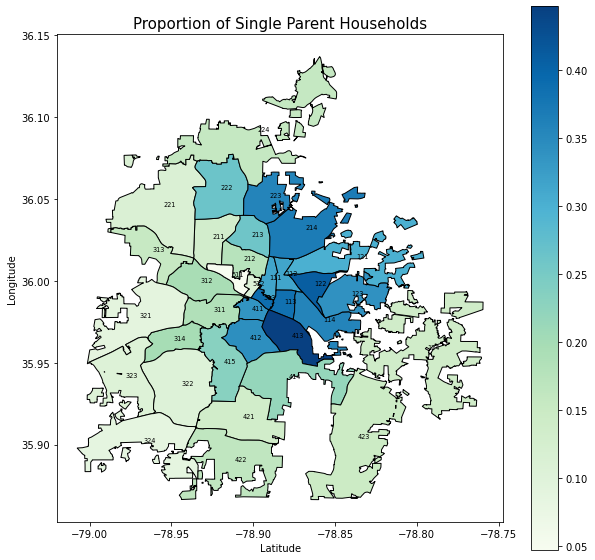

In [236]:
#Plot choropleth map with merged data
fig, ax = plt.subplots(figsize = (10,10))
singleparent.plot(column='prop_singleparent',
                                legend=True,
                                cmap="GnBu", ax=ax, aspect=1, edgecolor = 'black');

texts = []

for x, y, label in zip(policebeats_points.geometry.x, policebeats_points.geometry.y, policebeats_points["LAWBEAT"]):
    texts.append(plt.text(x, y, label, fontsize = 6.5))

plt.title("Proportion of Single Parent Households", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [237]:
#Print the five beats with the highest proportion of single parent households
highest_single = singleparent[['LAWBEAT', 'prop_singleparent']]
highest_single.sort_values(by='prop_singleparent', inplace=True, ascending=False)
highest_single.head()

,LAWBEAT,prop_singleparent
26,413,0.447121
5,122,0.409044
34,513,0.389016
2,113,0.384542
11,214,0.367529


In [238]:
#Filter out for community safety beats
commsafe_singleparent = singleparent.loc[singleparent['LAWBEAT'].isin(commsafe_list)]

#Filter out for group 1 beats
group1_singleparent = singleparent.loc[singleparent['LAWBEAT'].isin(group1_list)]

#Filter out for group 2 beats
group2_singleparent = singleparent.loc[singleparent['LAWBEAT'].isin(group2_list)]

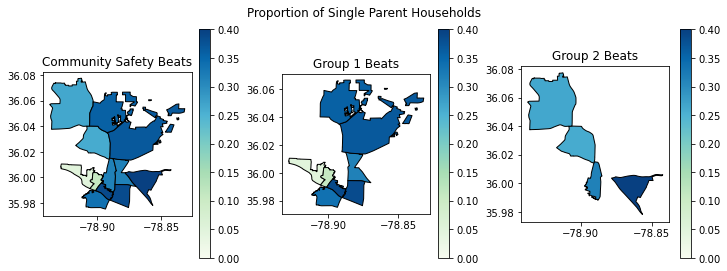

In [249]:
#Plot subplots of householdincome
fig = plt.figure(constrained_layout=True, figsize=(10, 10))

vmin, vmax=0, 0.4

gridspan = fig.add_gridspec(1, 1)
gs = GridSpec(3, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax1.title.set_text('Community Safety Beats')
ax2.title.set_text('Group 1 Beats')
ax3.title.set_text('Group 2 Beats')

# Set figure title
fig.suptitle("Proportion of Single Parent Households")

#Plot subplots
commsafe_singleparent.plot(column='prop_singleparent',
                                legend=True,
                                cmap="GnBu", ax=ax1, vmin=vmin, vmax=vmax, aspect=1, edgecolor='black');

group1_singleparent.plot(column='prop_singleparent',
                                legend=True,
                                cmap="GnBu", ax=ax2, vmin=vmin, vmax=vmax, aspect=1, edgecolor='black');

group2_singleparent.plot(column='prop_singleparent',
                                legend=True,
                                cmap="GnBu", ax=ax3, vmin=vmin, vmax=vmax, aspect=1, edgecolor='black');

plt.show()